# Clustering

In [19]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import  SpectralClustering, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_samples, \
silhouette_score, classification_report
from sklearn.decomposition import PCA

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)
from tqdm import tqdm_notebook
from sklearn.preprocessing import Normalizer

RAND=10

In [2]:
# Функции для задачи кластеризации
def calculate_optimal_distance(list_clusters, list_score):
    """
    Поиск наибольшего расстояния для метода локтя
    """
    x1, y1 = list_clusters[0], list_score[0]
    x2, y2 = list_clusters[-1], list_score[-1]
    A, B, C = y1 - y2, x2 - x1, x1 * y2 - x2 * y1

    max_dist = -np.inf
    max_x = -np.inf
    for num, i in enumerate(list_score[1:-1]):
        x_0, y_0 = list_clusters[1:-1][num], list_score[1:-1][num]
        dist = abs(A * x_0 + B * y_0 + C) / np.sqrt(A**2 + B**2)

        if dist > max_dist:
            max_dist = dist
            max_x = x_0
        else:
            continue
    return max_dist, max_x


def elbow_picture(labels_std: list,
                  labels_min: list,
                  labels_max: list,
                  labels_median: list,
                  type_optimal: list,
                  min_size: int,
                  max_size: int):
    """
    Метод локтя

    Функция для вывода графика зависимостей стандартной ошибки, 
    минимального и максимального числа объектов от кол-ва кластеров
    """

    _, opt_cluster = calculate_optimal_distance(
        range(min_size, max_size + 1), type_optimal)

    plt.figure(figsize=(8, 6))
    plt.plot(range(min_size, max_size + 1), labels_std,
             marker='s', color='green', label='std')
    plt.plot(range(min_size, max_size + 1), labels_min,
             marker='s', color='grey', linestyle='dashed', label='min')
    plt.plot(range(min_size, max_size + 1), labels_median,
             marker='o', color='skyblue', linestyle='dashed', label='median')
    plt.plot(range(min_size, max_size + 1), labels_max,
             marker='o', color='grey',  linestyle='dashed', label='max')
    plt.xlabel('Кластер')
    plt.ylabel('Станд.ошибка / Мин.кластер / Median / Макс.кластер')
    plt.axvline(x=opt_cluster, color='black',
                label=f'optimal clust= {opt_cluster}', linestyle='dashed')
    plt.legend()
    plt.show();


def silhouette_plot(data: pd.DataFrame, labels: pd.Series, metrics='euclidean', ax=None):
    """
    Функция вывода графика силуэтного скора
    """
    if ax is None:
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(7, 5)
        
    silhouette_vals = silhouette_samples(data, labels, metric=metrics)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals,
                 edgecolor='none', height=1)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Получение средней оценки силуэтного скора и построение графика
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score, linestyle='--', linewidth=1, color='red')
    ax.set_xlabel(f'Silhouette  = {round(avg_score,1)}')
    ax.set_ylabel('Метки кластеров')
    ax.set_title('График силуэта для различных кластеров', y=1.02)


def metric_picture(score_list: float, min_size: int, max_size: int,
                   name_metric, optimal: bool = True):
    """
    Функция для вывода графика зависимости силуэтной оценки от кол-ва кластеров
    """
    plt.figure(figsize=(8, 6))
    if optimal:
        _, opt_cluster = calculate_optimal_distance(
            range(min_size, max_size + 1), list_score=score_list)
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.axvline(x=opt_cluster, color='black',
                    label=f'optimal clust= {opt_cluster}', linestyle='dashed')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    else:
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    plt.show()
    

def check_fullness(data, labels):
    """
    Функция для проверки медианной заполненности кластера
    Для бинаризованных данных
    """
    sums = []
    #Пробегаем по кластерам
    for label in np.unique(labels):
        #Находим медианную заполненность кластера
        cluster_quantile = data[labels == label].sum(axis = 0).quantile(.5)
        sums.append(cluster_quantile)
    pd.DataFrame(sums).sort_values(by = [0]).plot(kind = "barh", figsize = (8, 6))
    plt.title('Заполненность кластеров')
    plt.ylabel('clusters')
    plt.show()
    

def plot_size(data: pd.DataFrame, labels: pd.Series):
    """
    Фунция для вывода графика размера кластеров    
    """
    plt.title('Размер кластеров')
    cluster_size = data.assign(cluster=labels).groupby(
        'cluster').count().iloc[:, 0]
    cluster_size.sort_values().plot.barh(figsize=(6, 4), color='C0')
    plt.show()
    
    
def plot_top_features(data, labels, n_clusters):
    """
    ТОП-признаки для бинаризованных данных
    """
    binary_label = data.assign(cluster = labels)
    size_cluster = binary_label.groupby('cluster').count().iloc[:,0]
    data_sum = binary_label.groupby('cluster').sum()
    data_sum_norm = data_sum.T / size_cluster

    fig, ax_lst = plt.subplots(n_clusters, 1, figsize = (6,n_clusters*5))
    plt.subplots_adjust(wspace=0.8, hspace=0.3)
    for i in range(n_clusters):
        ax_lst.reshape(-1)[i].set_title('cluster = ' + str(i));
        data_sum_norm.loc[:,i].sort_values()[-10:].plot.barh(ax=ax_lst.reshape(-1)[i], color='C0');
    plt.show();

Попробуем разбить датасет на кластеры и предсказать для каждого из них вероятность быть трудоустроенным в течение года.<br> Для этого разобьём данные людей из выборки на кластеры по социальным признакам и описать их, затем посмотрим, кто будет предположительно трудоустроен в течение года. Удалим признак "Месяц рождения", как не влияющий на социальные орментиры.

In [9]:
# Импорт данных (таблицы из файла)
df = pd.read_csv('Train.csv')

# Удаляем неинформативные признаки: ID, Дату опроса и столбец, в котором практически все значения одинаковые 
df = df.drop(["Person_id", "Survey_date", "Sa_citizen", "Round", 'Birthmonth'], axis = 1)

# Часть пропусков можно заполнить нулями
df['Tenure'] = np.where(df.Status == 'studying', 0, df.Tenure)
df['Tenure'] = np.where(df.Status == 'other', 0, df.Tenure)

# Остальные в признаке заполняем модой
df.Tenure = df.Tenure.fillna(df.Tenure.mode()[0])

# Заполним пропуски в остальных признаках значением 'None', т.к. они либо категориальные, либо бинарные.
df = df.fillna('None')

In [10]:
# Вычислим количество компонент, удаляем признак по ожиданию трудоустройства.
X = pd.get_dummies(df.drop(['Target'], axis=1))

# Пропишем цикл обработки для любого количества столбцов для удвление неинформативных признаков  None
for i in list(X):
    if '_None'  in i:
        X = X.drop(i, axis=1)

In [11]:
#Нормализуем данные
t = Normalizer().fit(X)
normt = t.transform(X)

In [12]:
pca = PCA(n_components=3, random_state=RAND)
X_embedding = pca.fit_transform(normt)

for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))

1 component: 98.35% of initial variance
2 component: 1.65% of initial variance
3 component: 0.0% of initial variance


In [ ]:
# Логарифм для признаков Tenure и Birthyear не можем использовать,
# так как он даёт +-inf, котоый нельзя передать в PCA.

In [15]:
# Разобьем числовые признаки на бины в соответствии с их нестандартным распределением (ноутбук с EDA),
# чтобы в бины входили более-менее равномерные значения
# Создадим копию исходного датасета для бинаризации

dfb = df.copy()

def get_bins_(data: int) -> str:
    """
    Генерация бинов для признака "Год рождения"
    """
    if isinstance(data, (int, float)):
        if data <= 1999:
            return 'before_2000'
        elif data >= 2000:
            return '2000х'
dfb['Birthyear'] = dfb.Birthyear.apply(lambda x: get_bins_(x))

def get_bins_t(data: int) -> str:
    """
    Генерация бинов для признака "Длительность статуса"
    """
    if isinstance(data, (int, float)):
        if data == 0.0:
            return 'NoTenure'
        elif data != 0.0:
            return 'AnyTenure'
        
dfb['Tenure'] = dfb.Tenure.apply(lambda x: get_bins_t(x))
dfb.Female = dfb.Female.astype('object')

Xb = pd.get_dummies(dfb.drop(['Target'], axis=1))

# Удалим признаки с None, так как это неопределенные значения, не дают описания кластеров.
for i in list(Xb):
    if '_None'  in i:
        Xb = Xb.drop(i, axis=1)
        
# Нормализуем данные
tlogbin =  Normalizer().fit(Xb)
normtlogbin = tlogbin.transform(Xb)
pca = PCA(n_components=3, random_state=RAND)

X_embedding = pca.fit_transform(normtlogbin)

for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))


1 component: 13.28% of initial variance
2 component: 10.57% of initial variance
3 component: 8.24% of initial variance


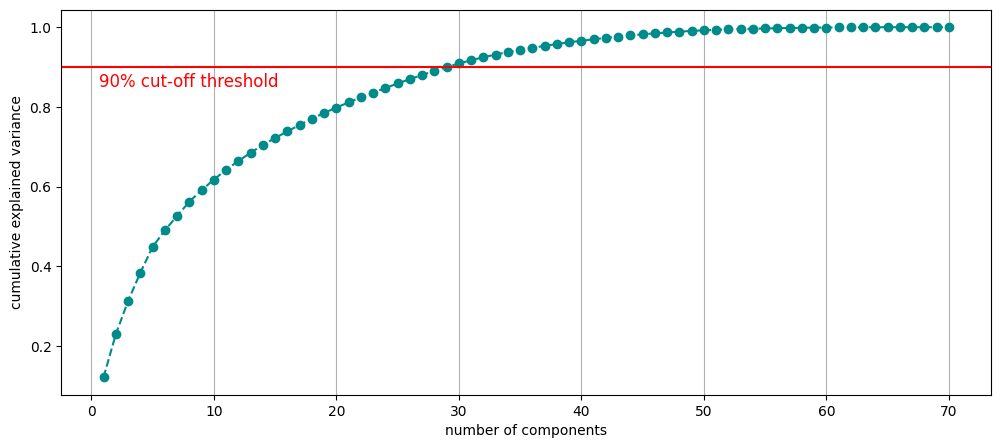

In [16]:
plt.figure(figsize=(12, 5))

pca = PCA().fit(Xb)

x = np.arange(1, len(pca.explained_variance_ratio_)+1, 1)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='darkcyan')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.text(0.6, 0.85, '90% cut-off threshold', color = 'red', fontsize=12)
plt.grid(axis='x')

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Создание бинов дало лучшие результаты, с такой процентовкой можем более детально описать кластеры, необходимо около 30 компонент.

In [17]:
# Создадим списки для вывода метрик на график
labels_std = []
labels_min = []
labels_max = []
labels_median = []
calinski_harabasz = []
silhouette_list = []
min_size = 2
max_size = 8
calinski_harabasz = []
silhouette_list = []

  0%|          | 0/7 [00:00<?, ?it/s]

2 clusters
----------------------------------------------------------------------------------------------------


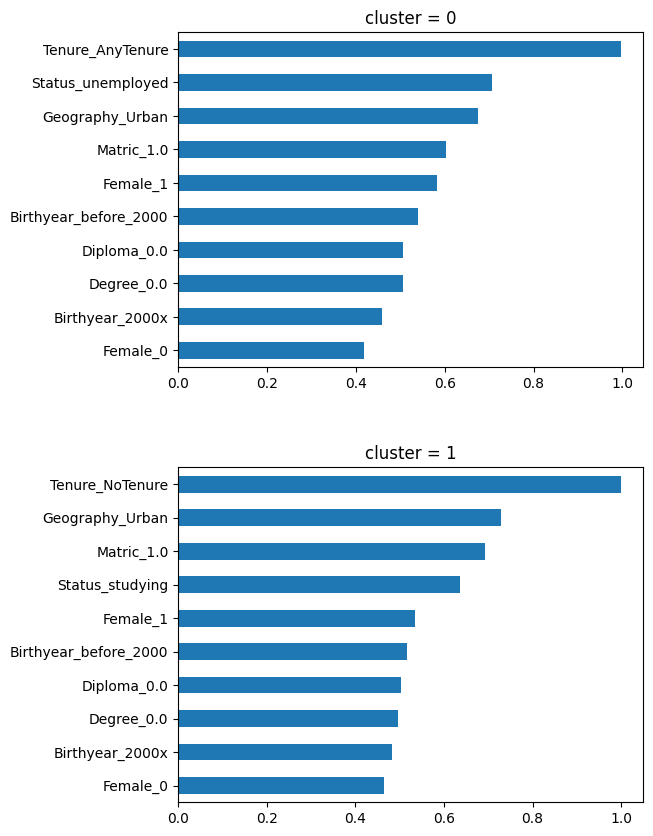

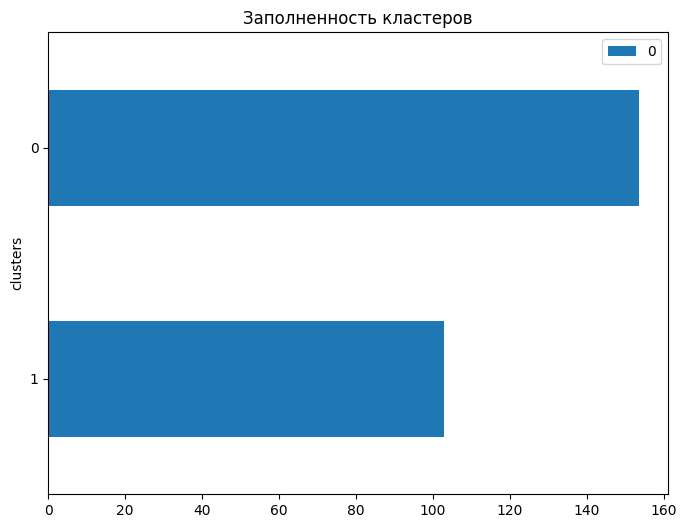

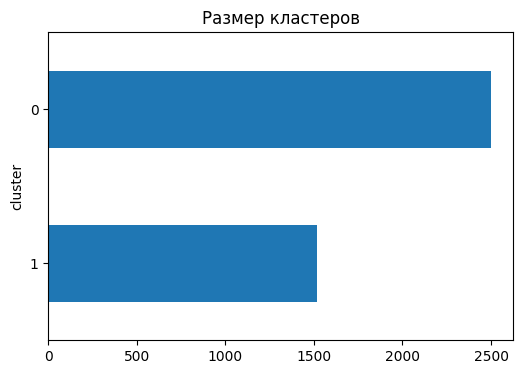

3 clusters
----------------------------------------------------------------------------------------------------


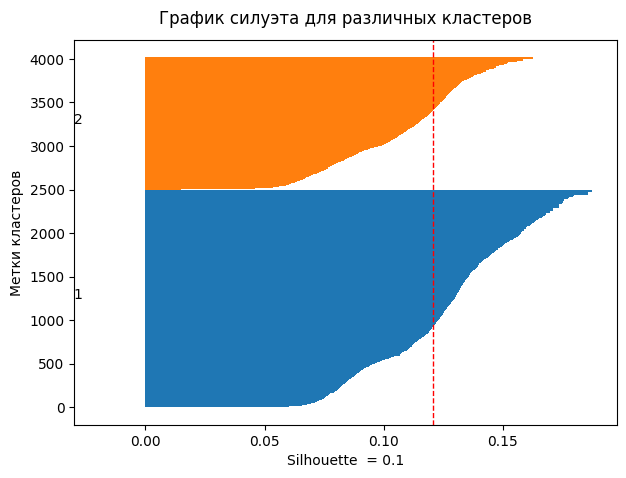

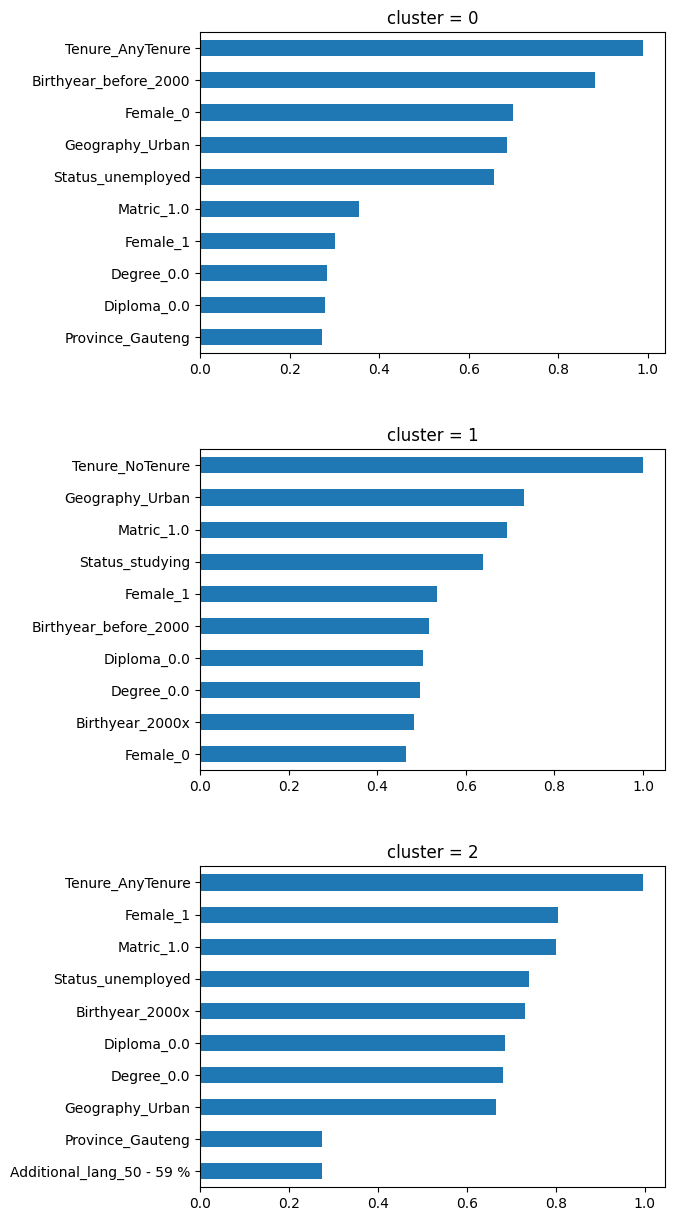

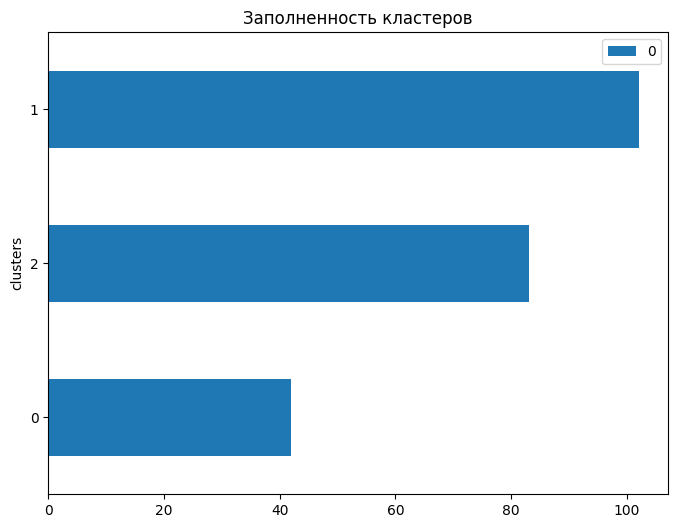

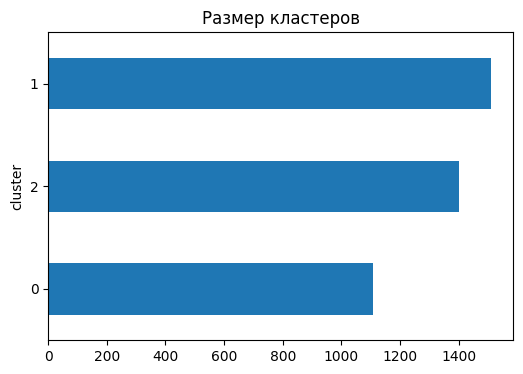

4 clusters
----------------------------------------------------------------------------------------------------


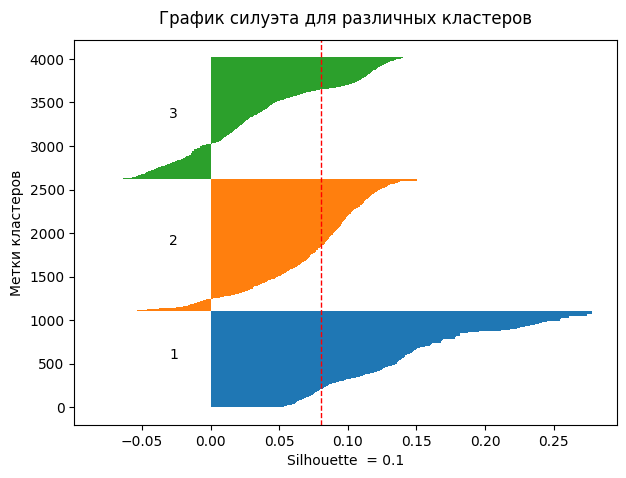

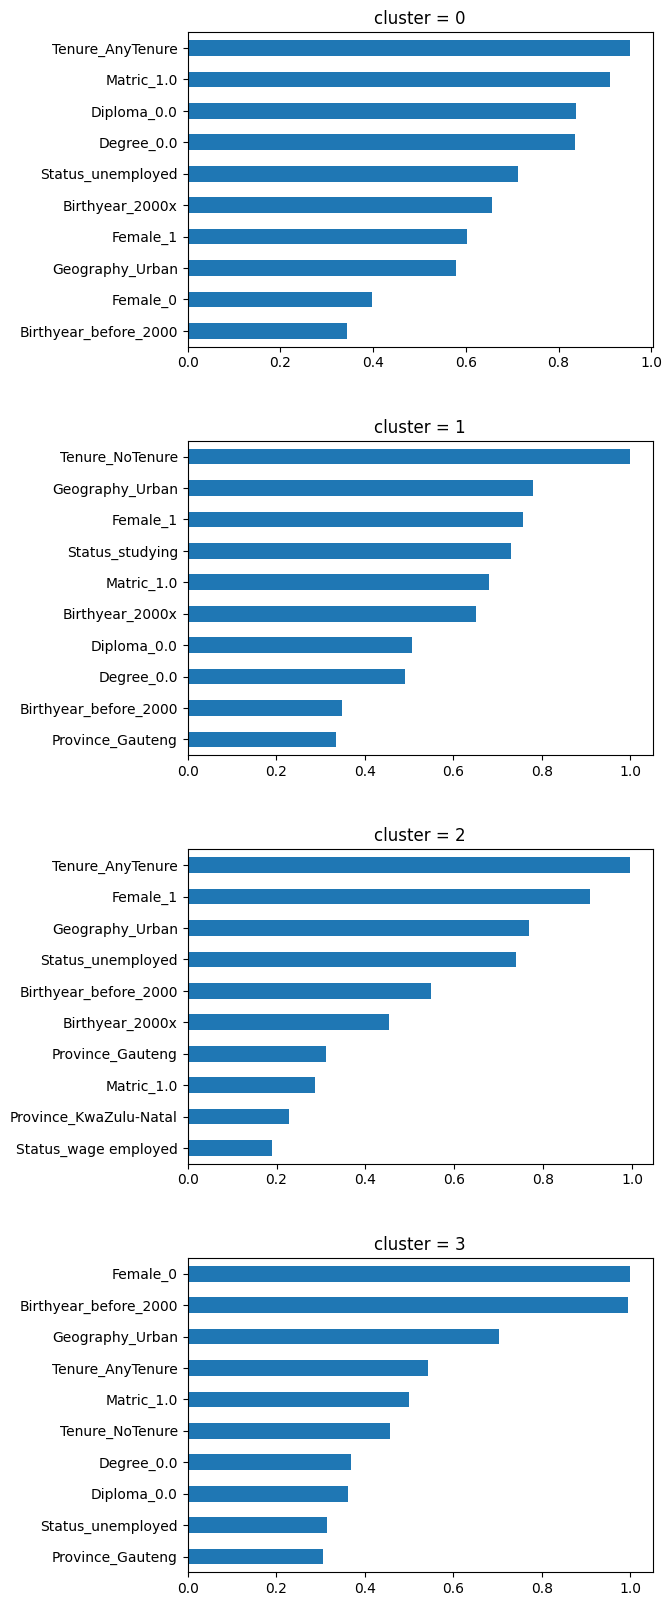

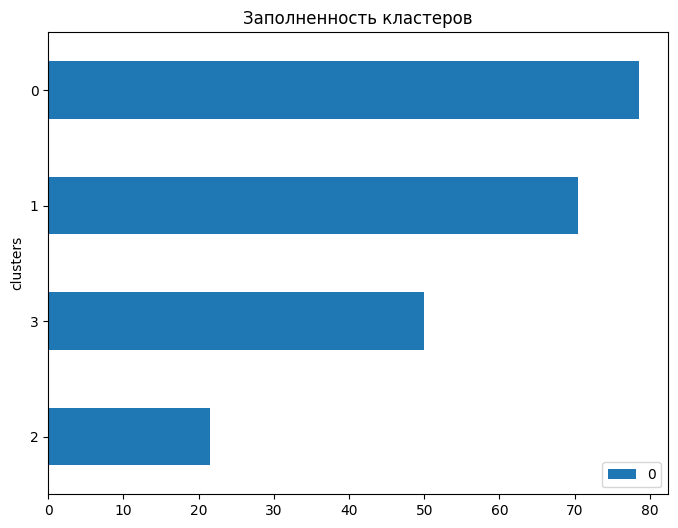

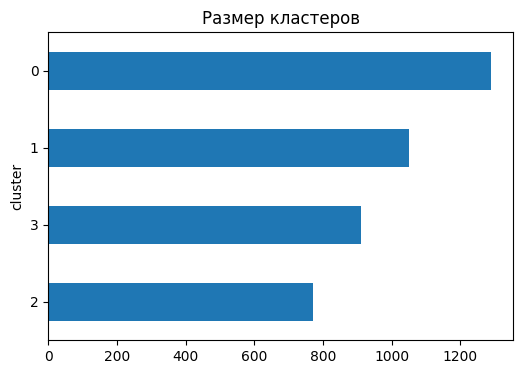

5 clusters
----------------------------------------------------------------------------------------------------


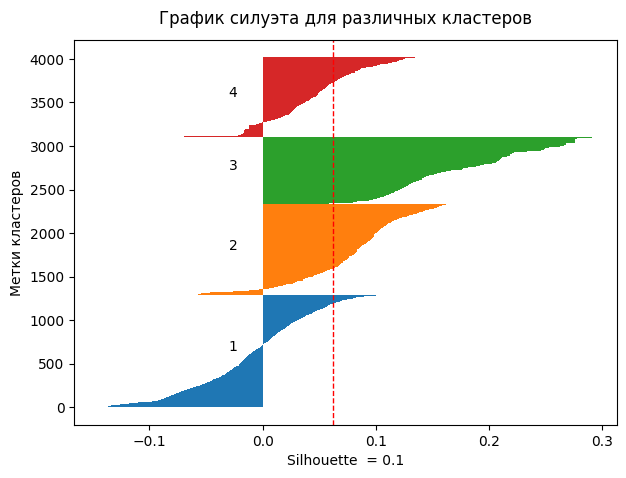

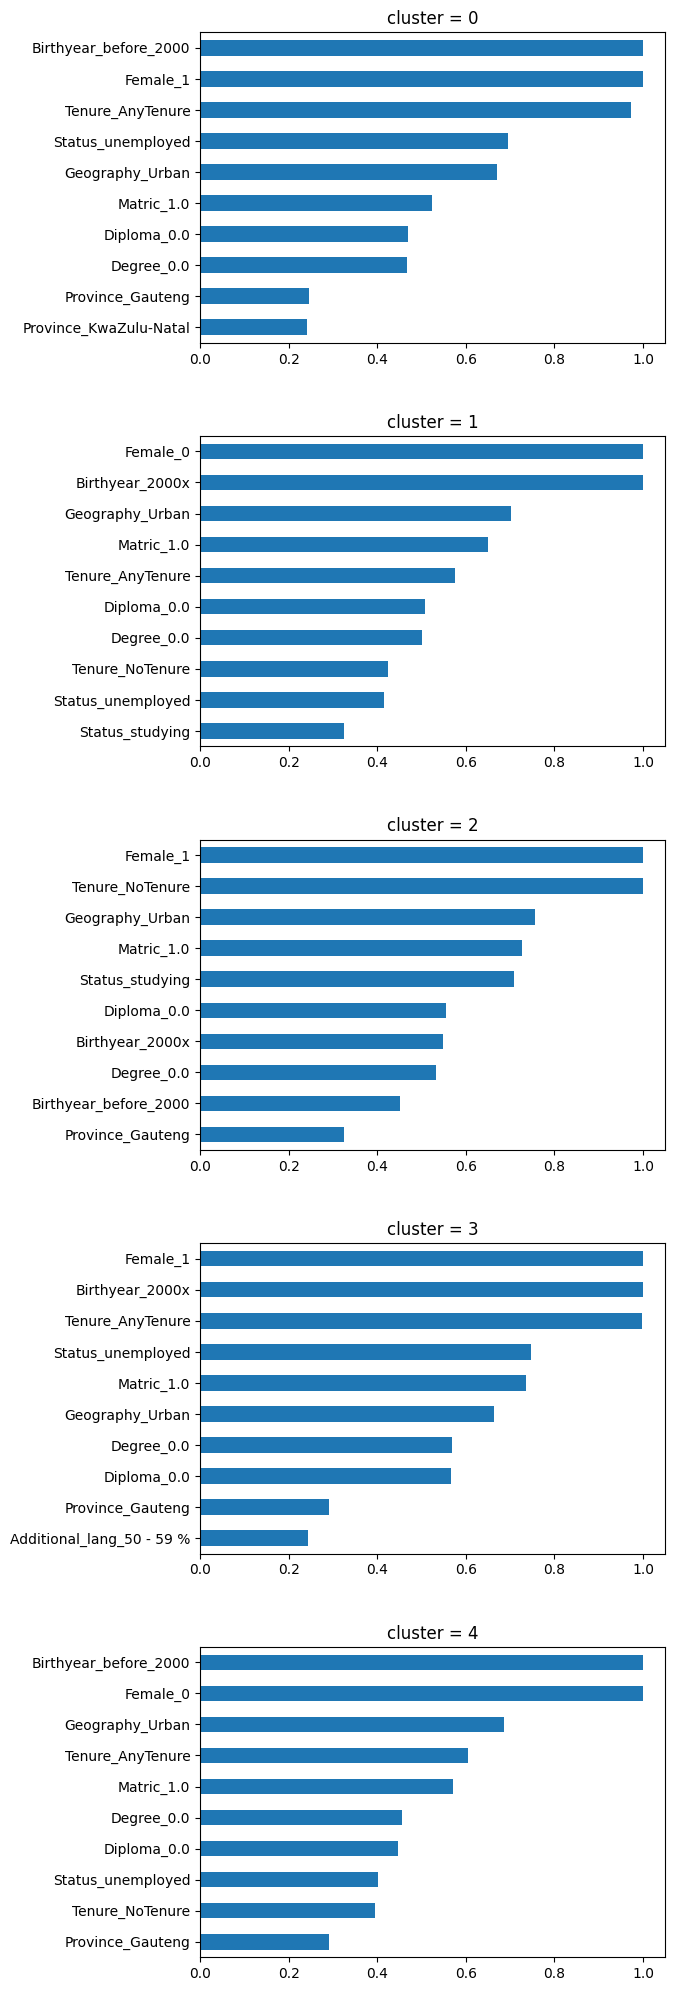

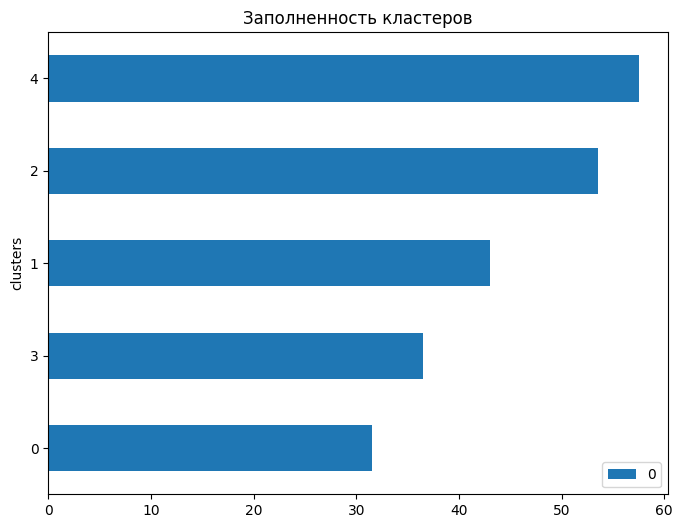

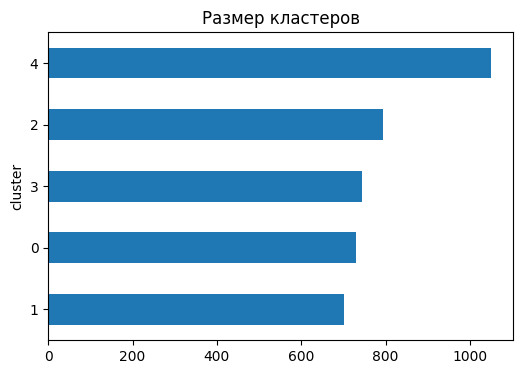

6 clusters
----------------------------------------------------------------------------------------------------


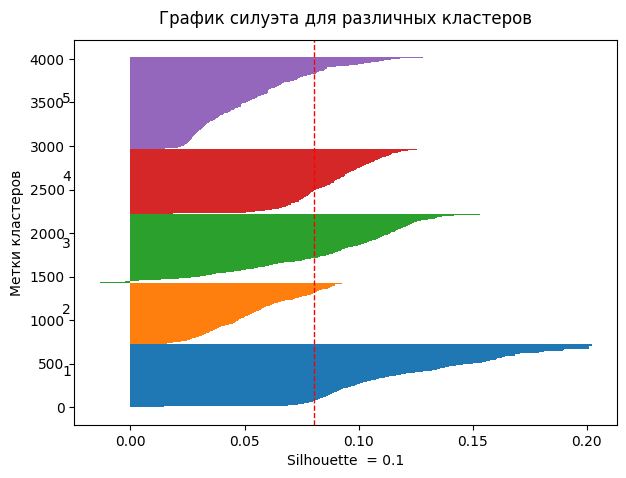

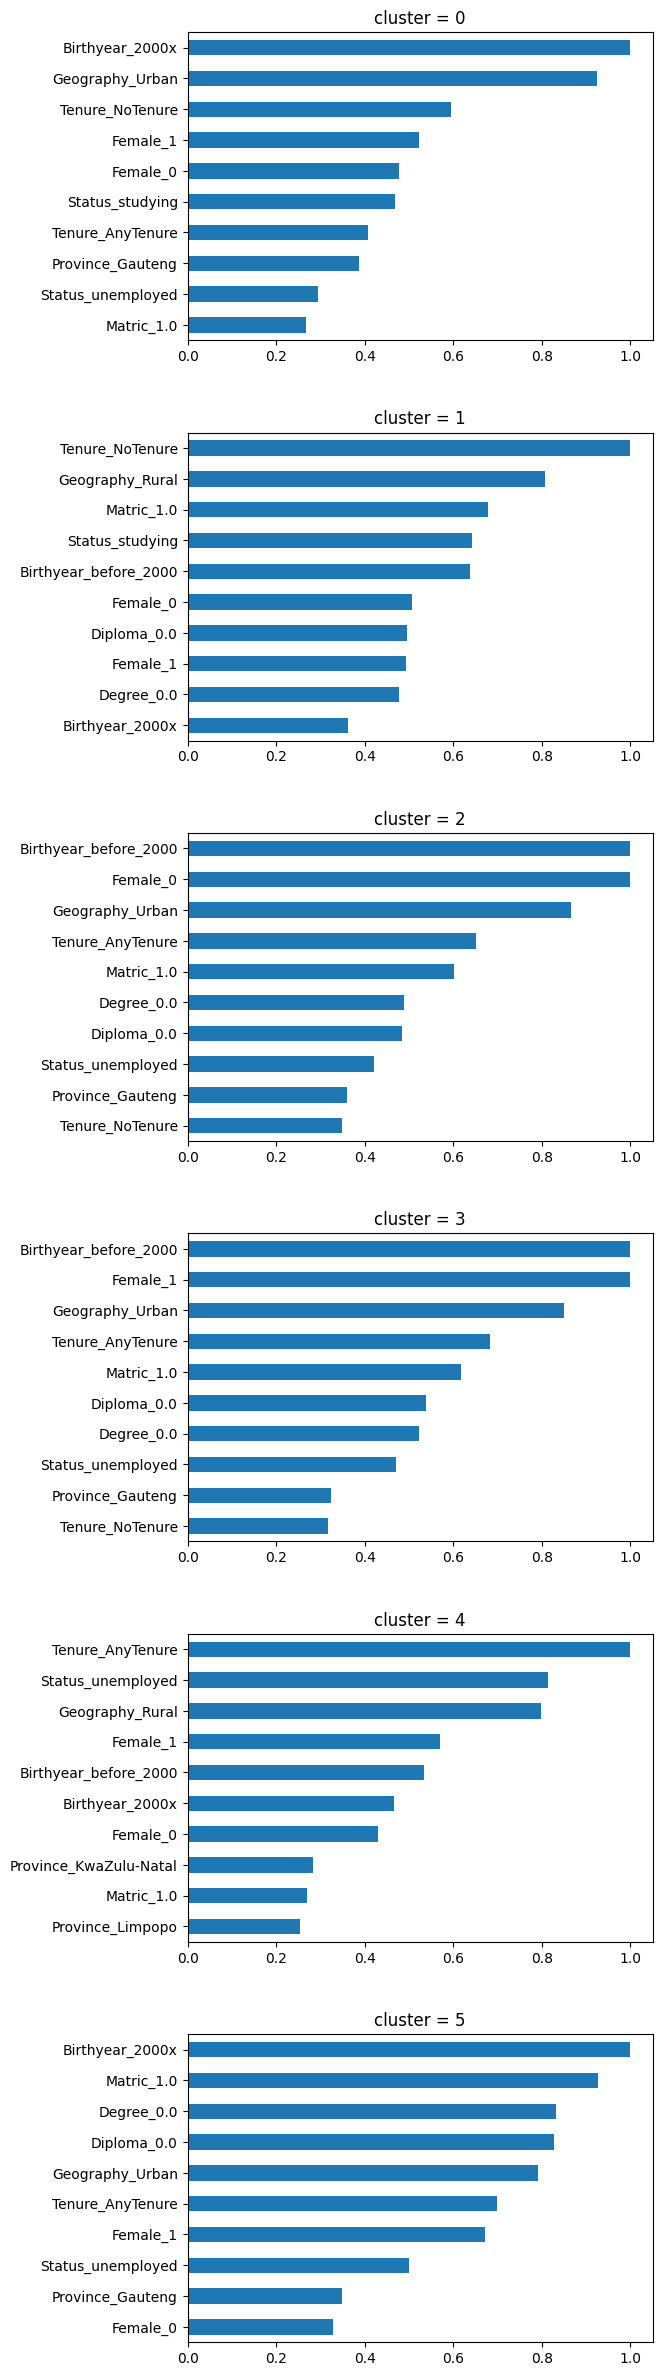

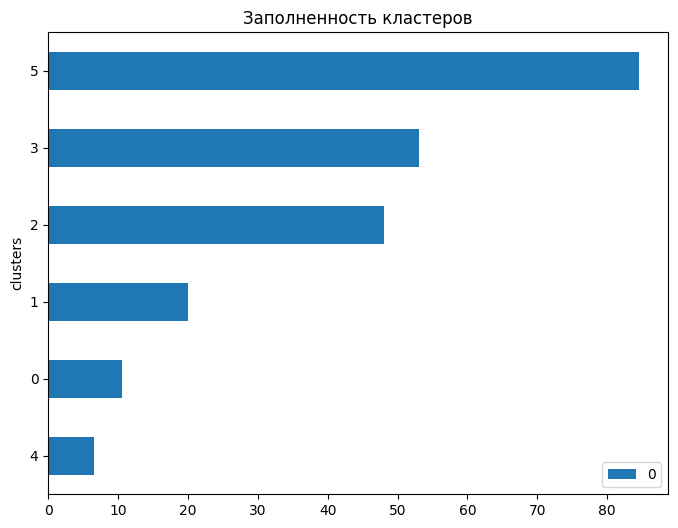

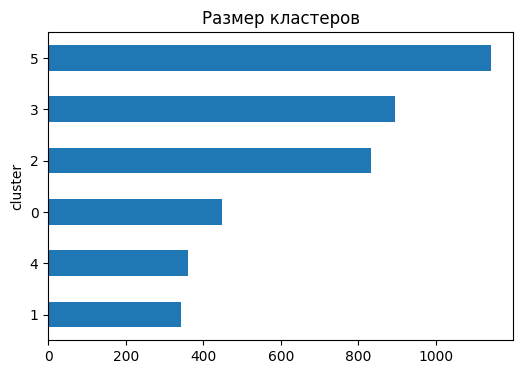

7 clusters
----------------------------------------------------------------------------------------------------


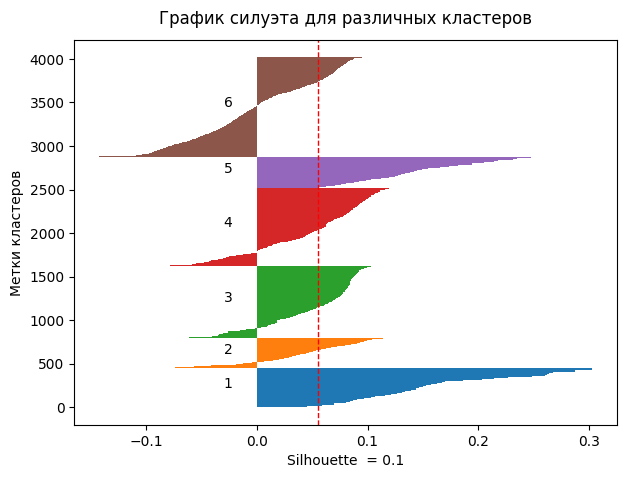

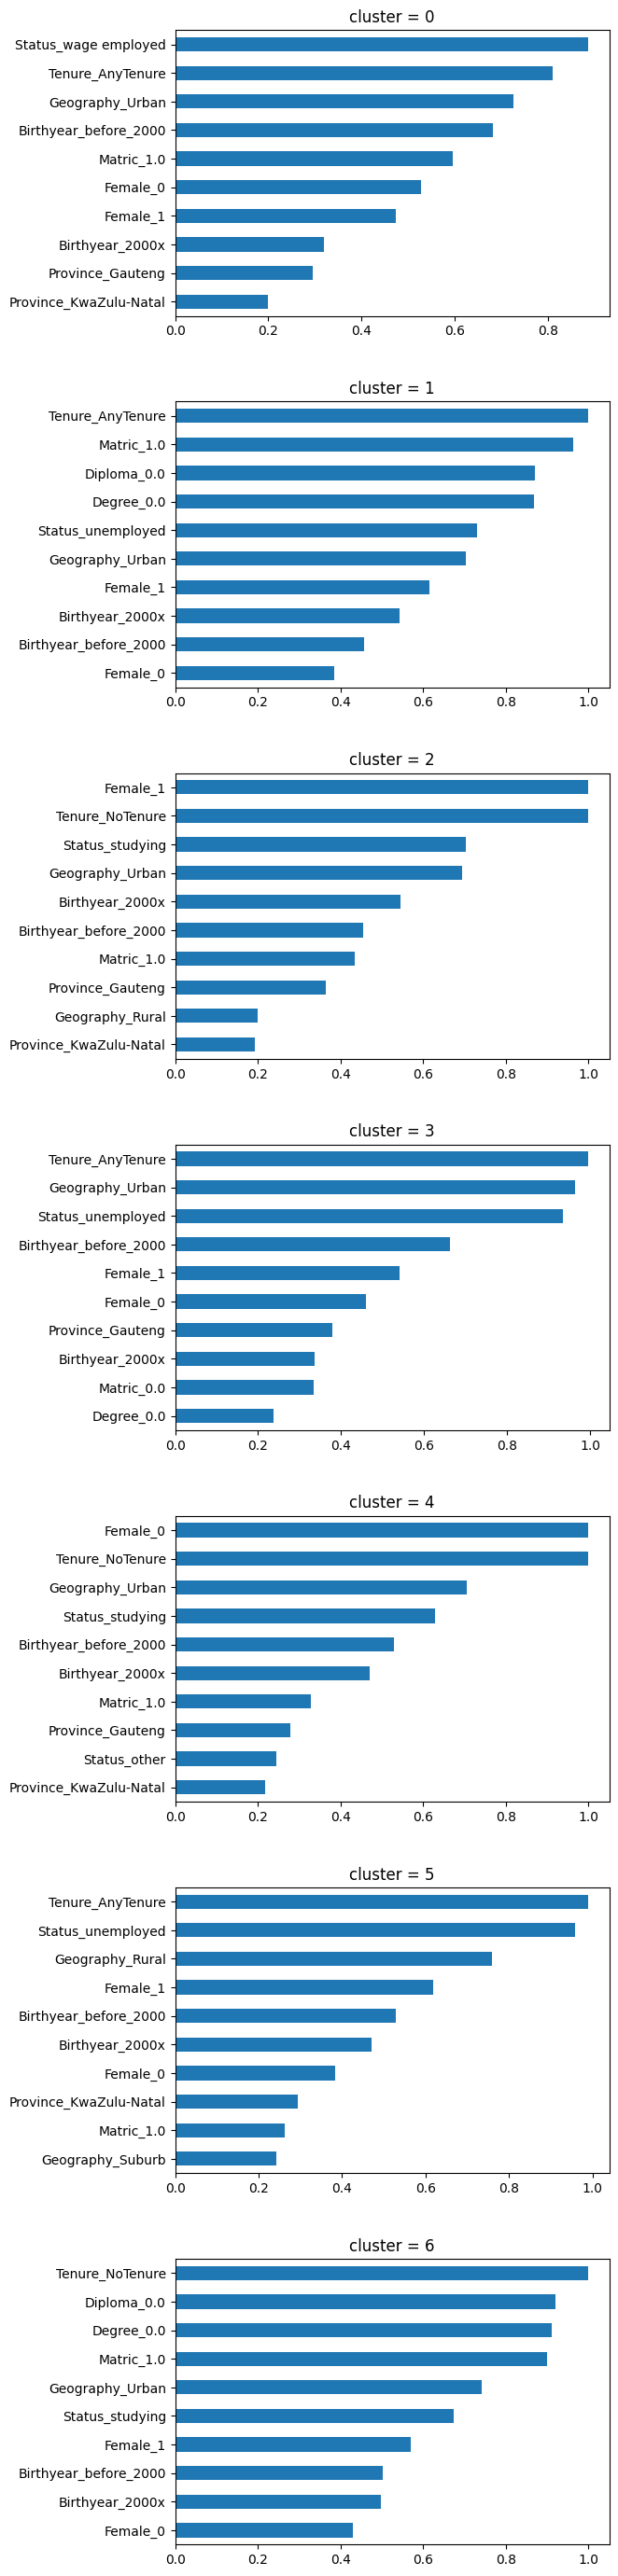

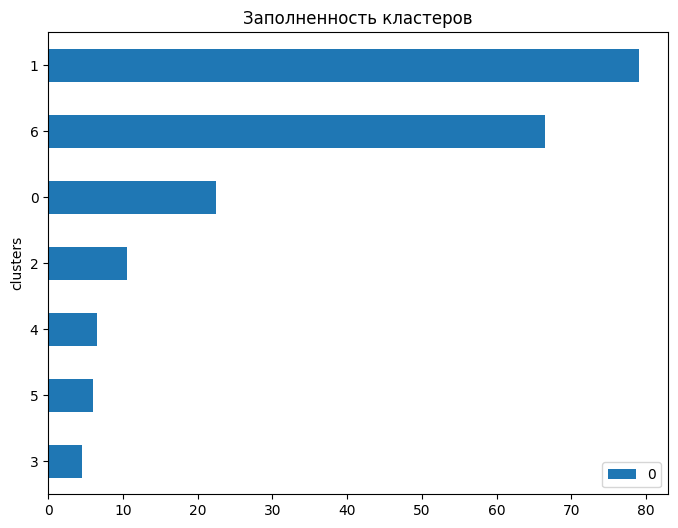

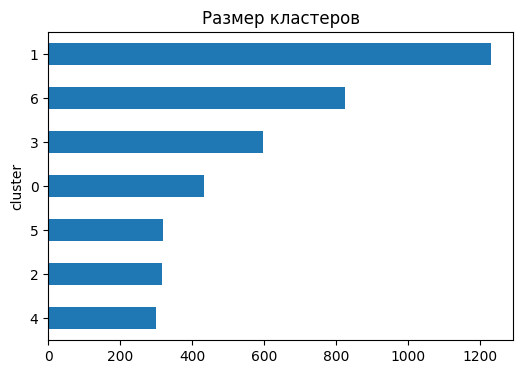

8 clusters
----------------------------------------------------------------------------------------------------


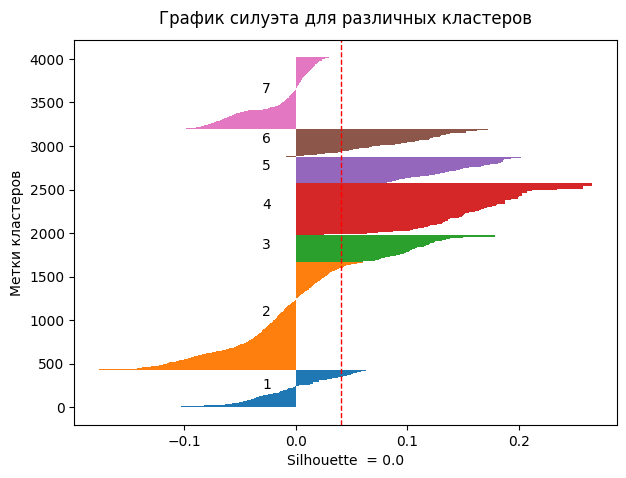

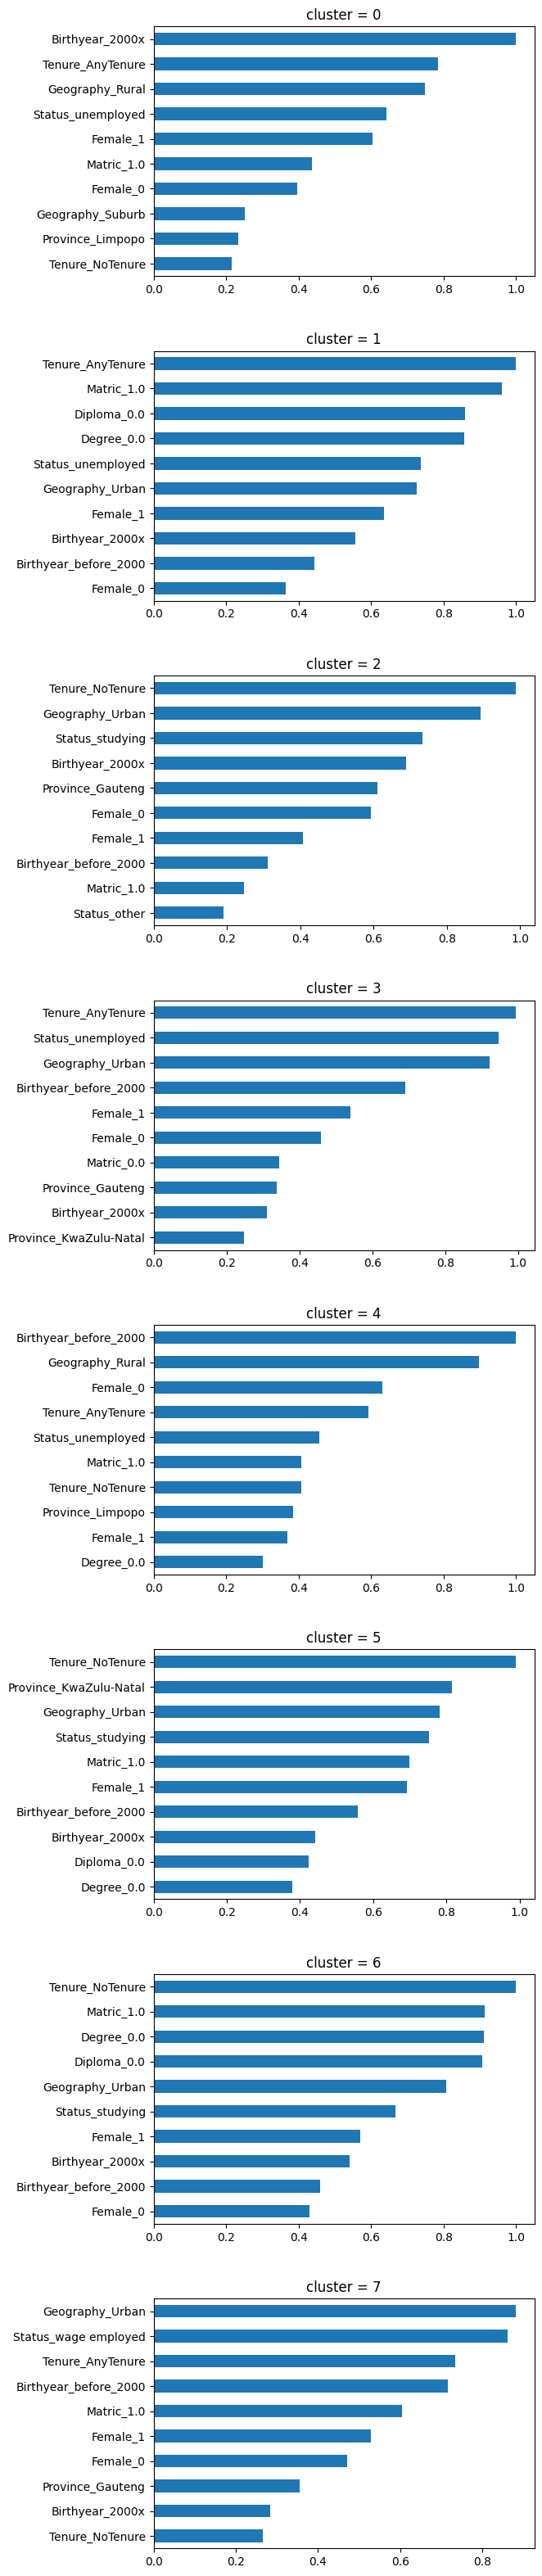

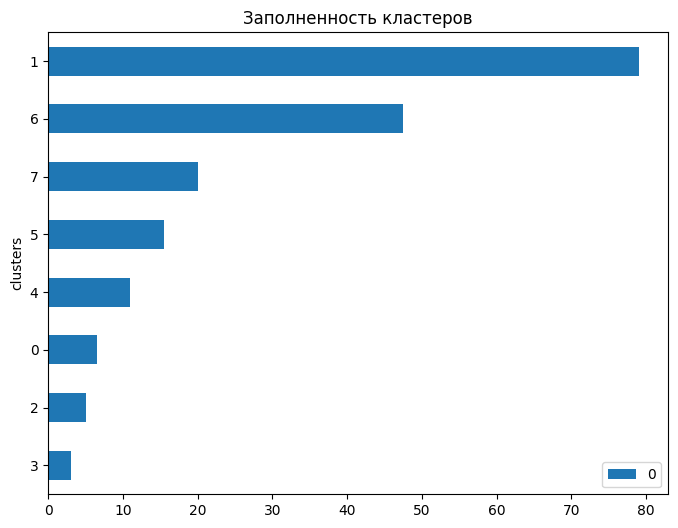

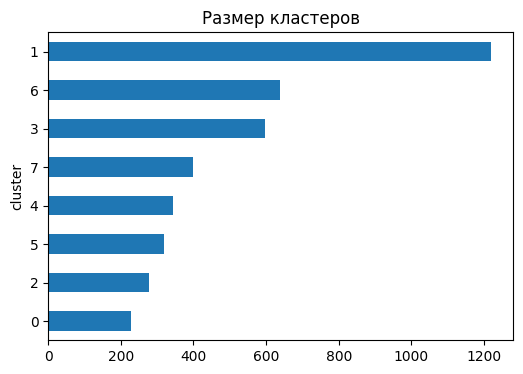

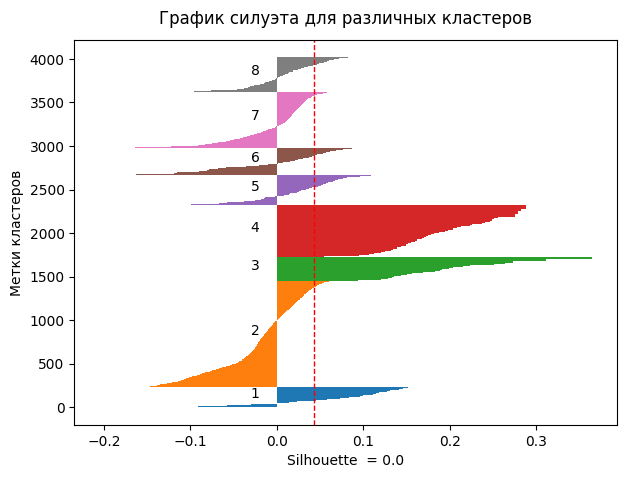

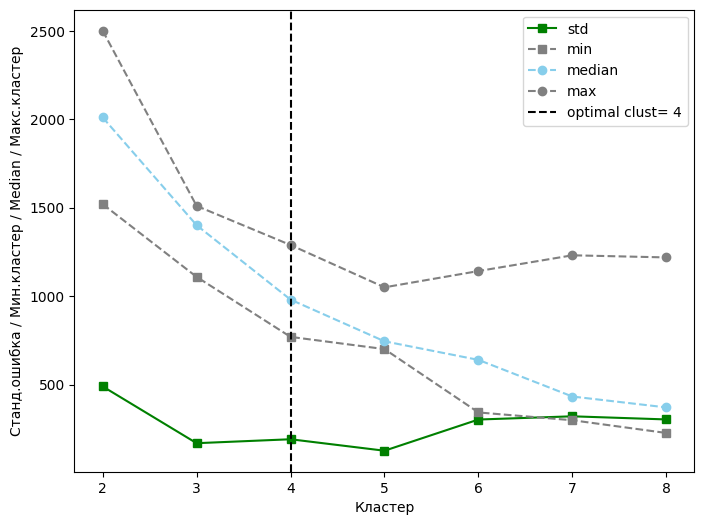

In [20]:
for clust in tqdm_notebook(range(min_size, max_size+1)):
    clf = SpectralClustering(n_clusters=clust, affinity='cosine')
    clf.fit(Xb)

    print(clust, 'clusters')
    print('-'*100)
    
    # топ-признаков
    plot_top_features(Xb, clf.labels_, clust)
    # медианная заполненность
    check_fullness(Xb, clf.labels_)
    # размер кластеров
    plot_size(Xb, clf.labels_)
    # график silhouette
    silhouette_plot(Xb, clf.labels_)
    # calinski_harabasz
    calinski_harabasz.append(calinski_harabasz_score(Xb, clf.labels_))
    # silhouette
    silhouette_list.append(silhouette_score(Xb, clf.labels_, metric='cosine'))

    _, counts = np.unique(clf.labels_, return_counts=True)

    labels_std.append(np.std(counts))
    labels_min.append(np.min(counts))
    labels_max.append(np.max(counts))
    labels_median.append(np.median(counts))


elbow_picture(labels_std, labels_min, labels_max,
              labels_median, labels_median, min_size, max_size)

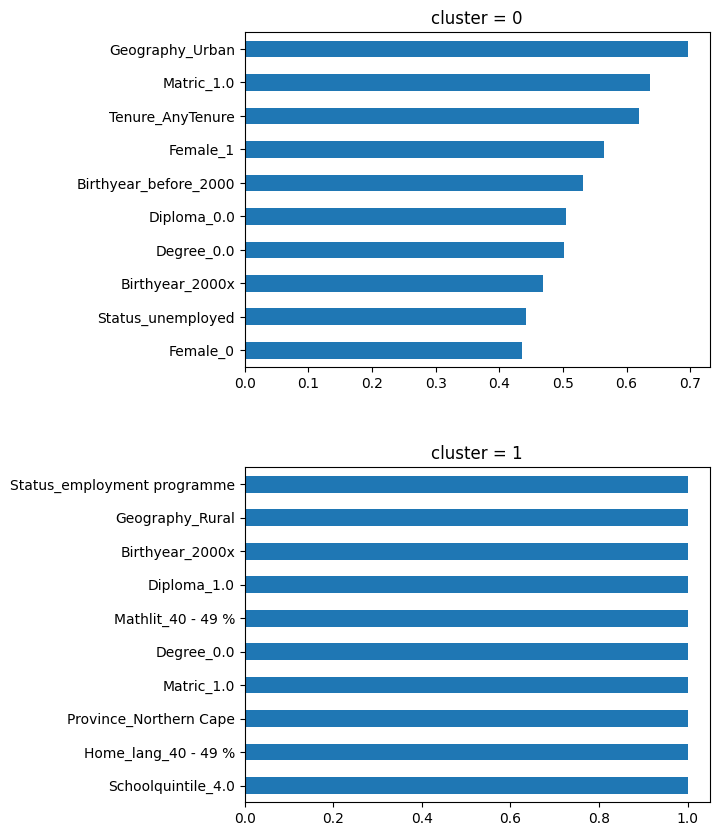

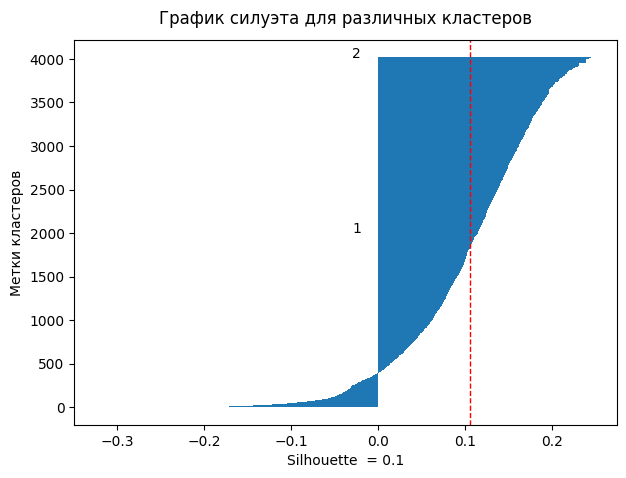

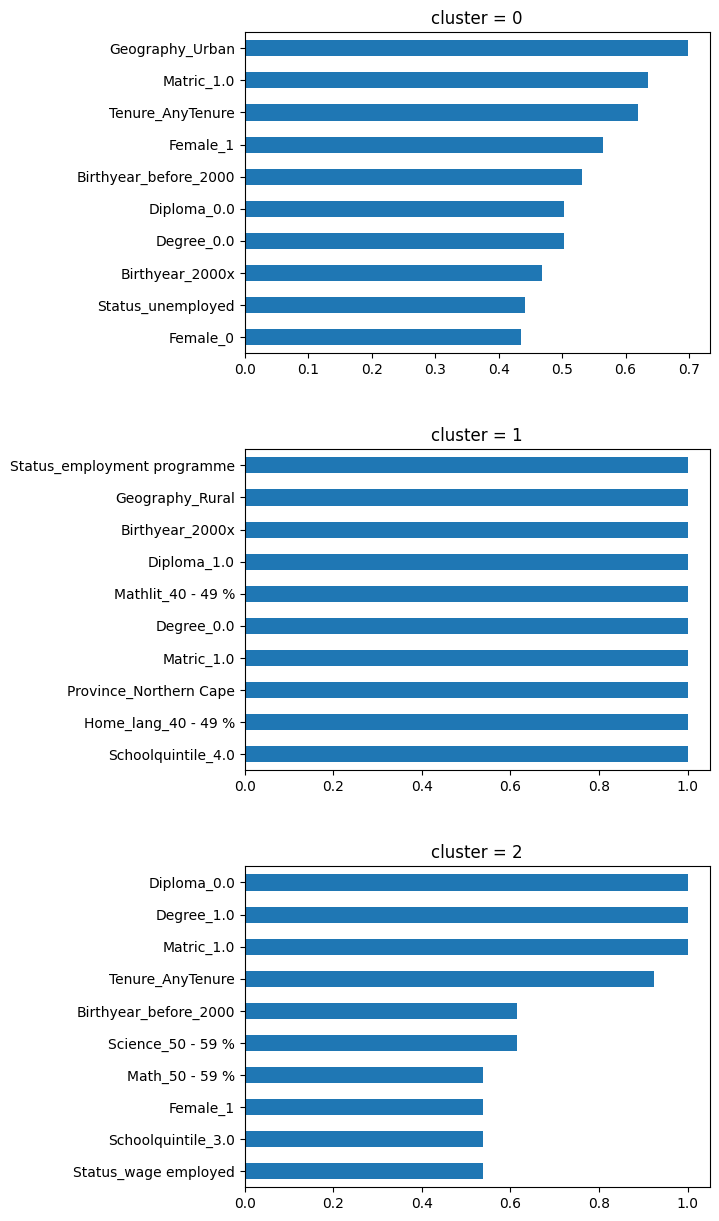

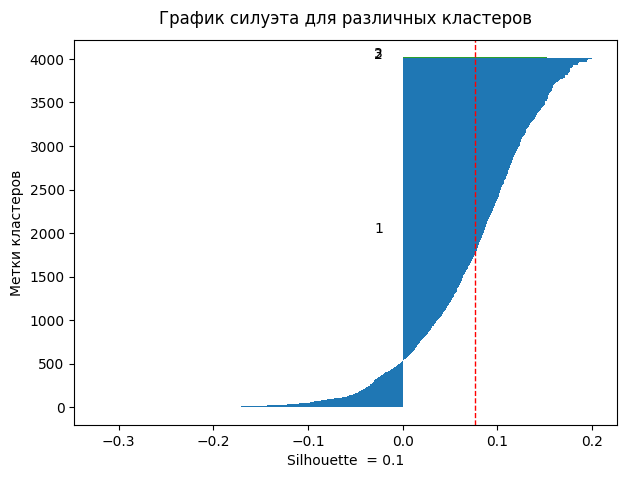

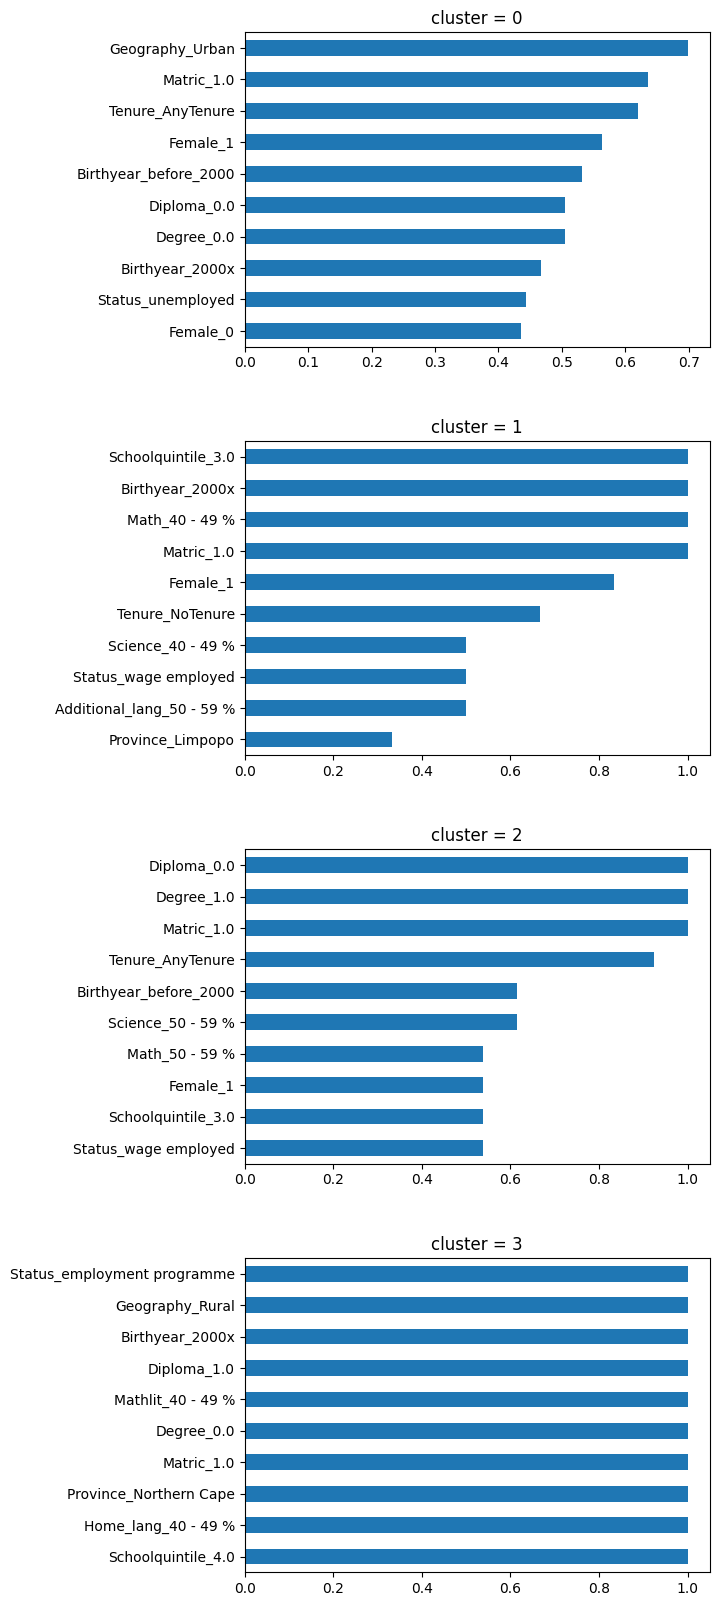

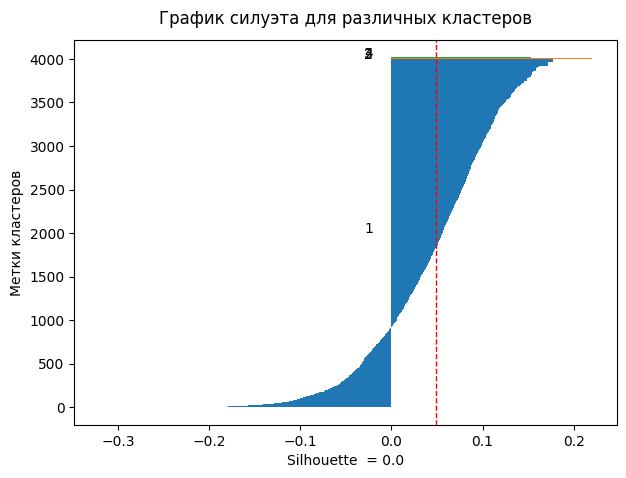

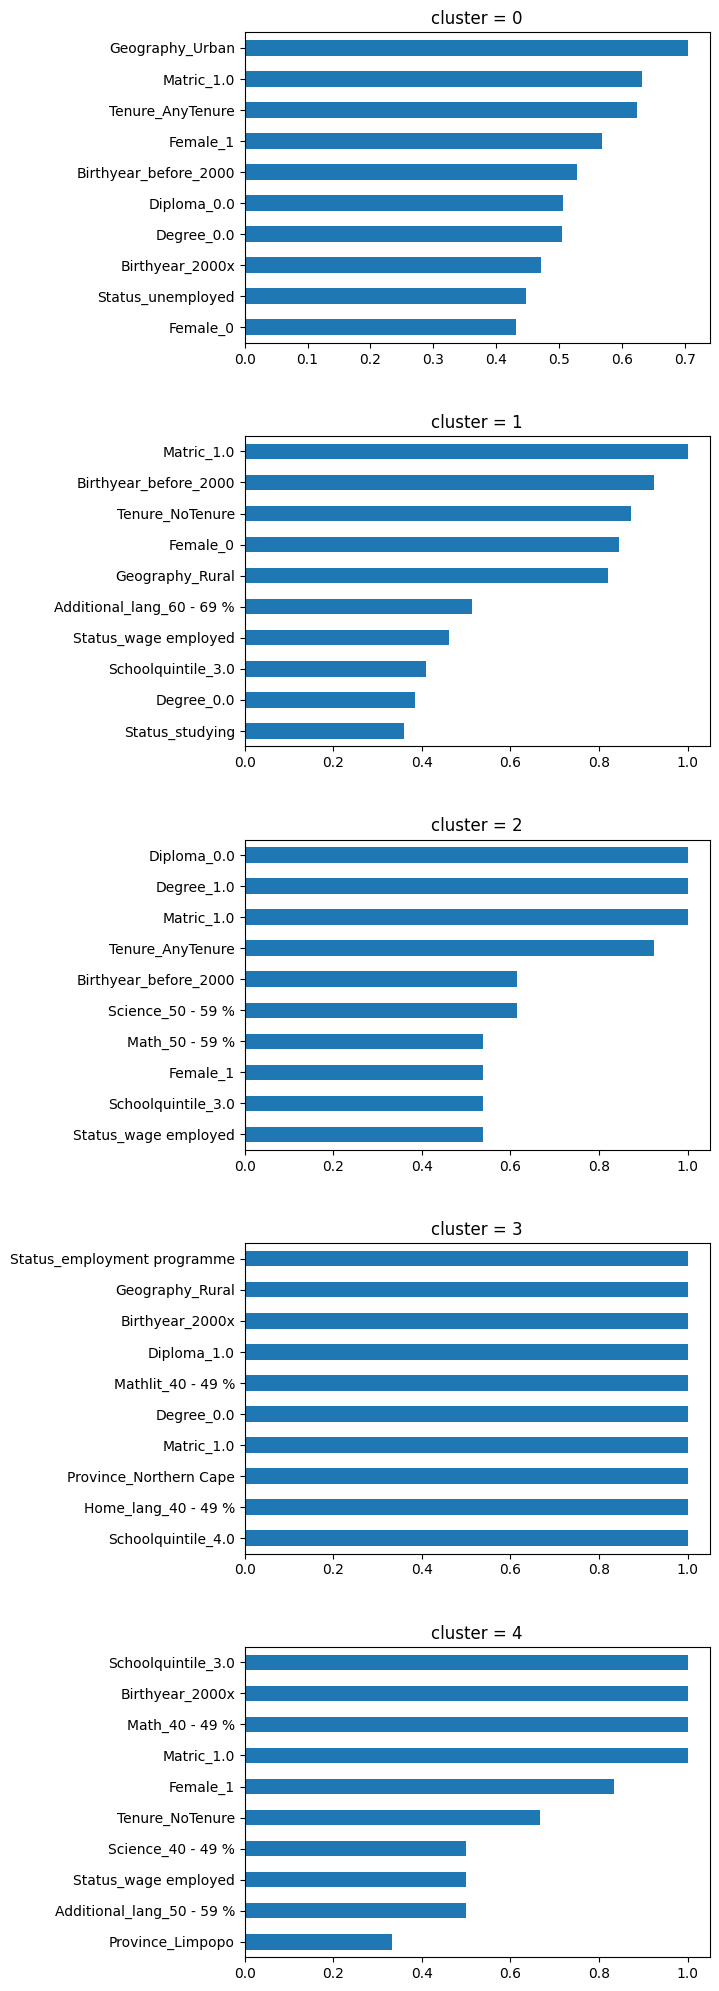

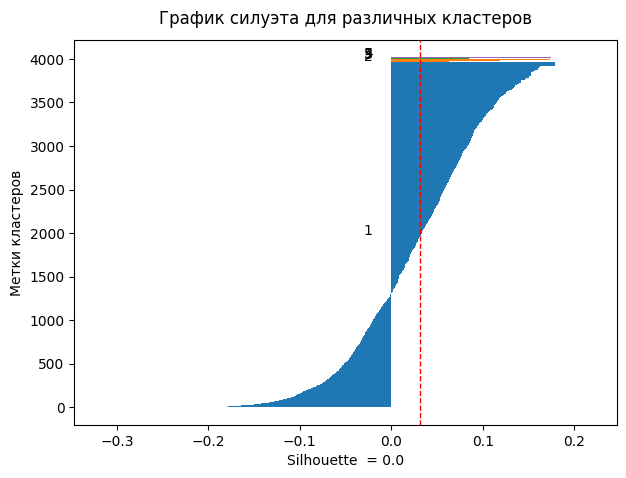

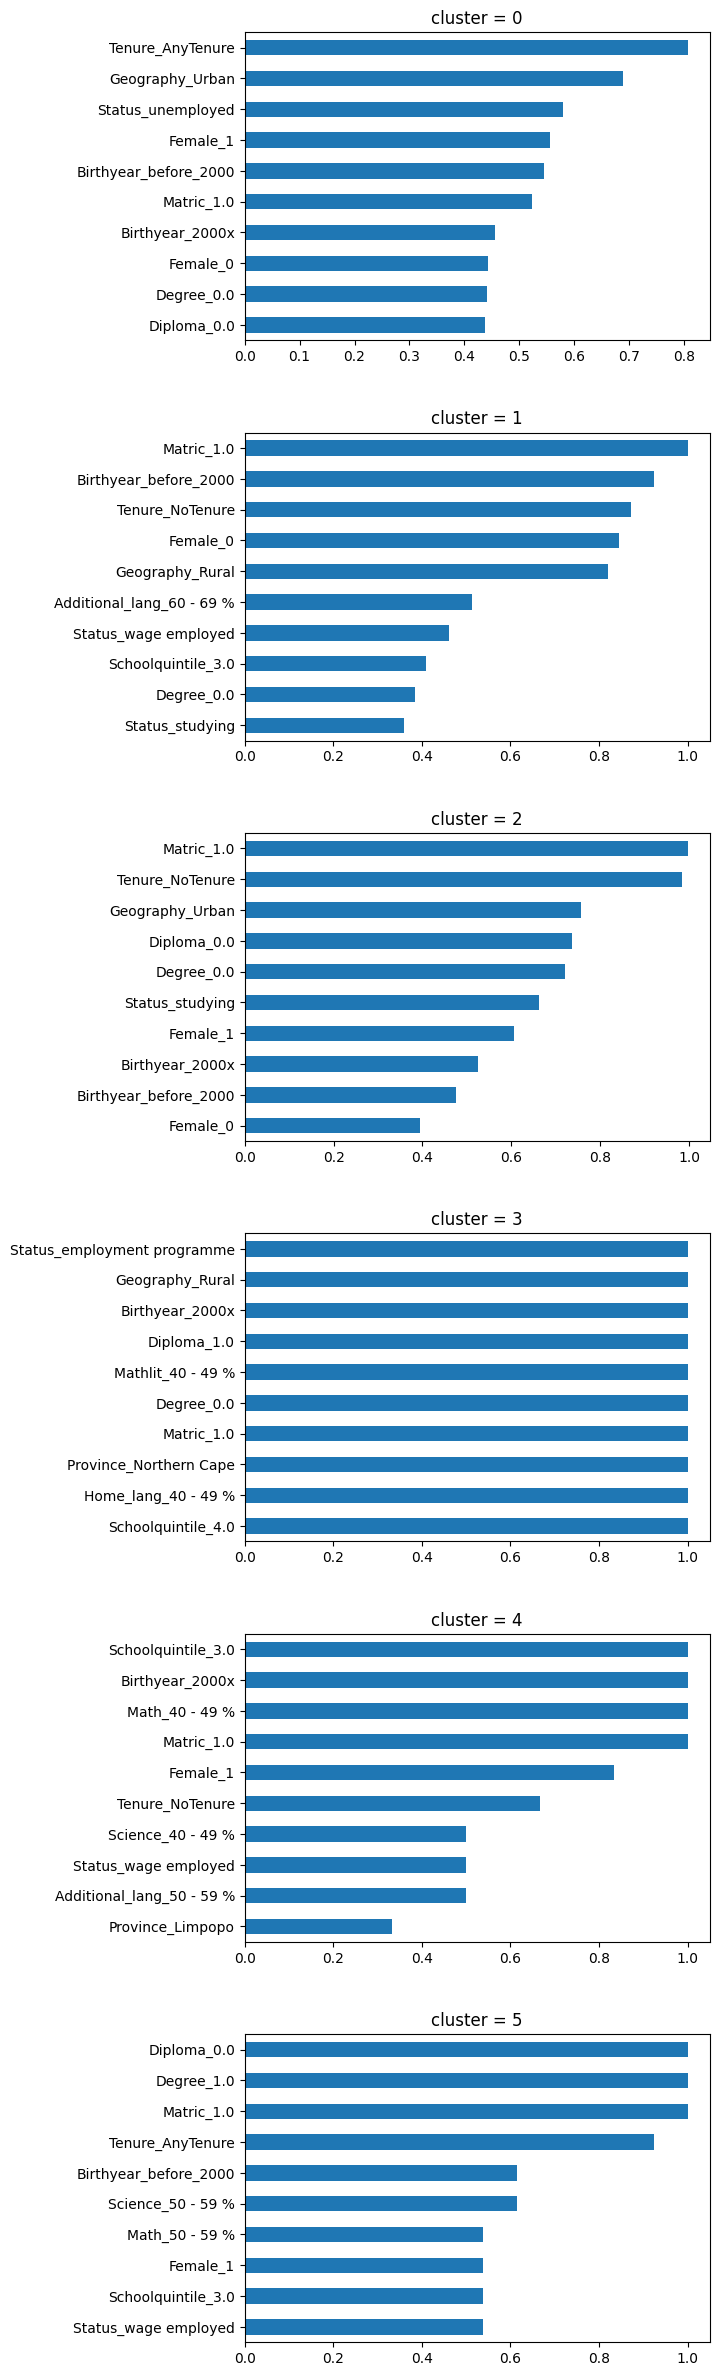

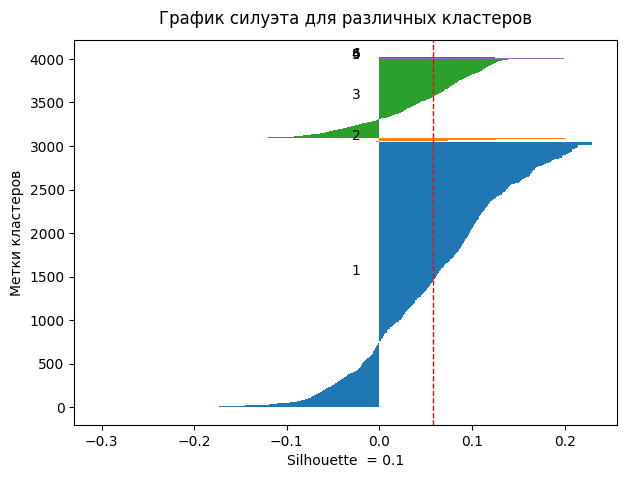

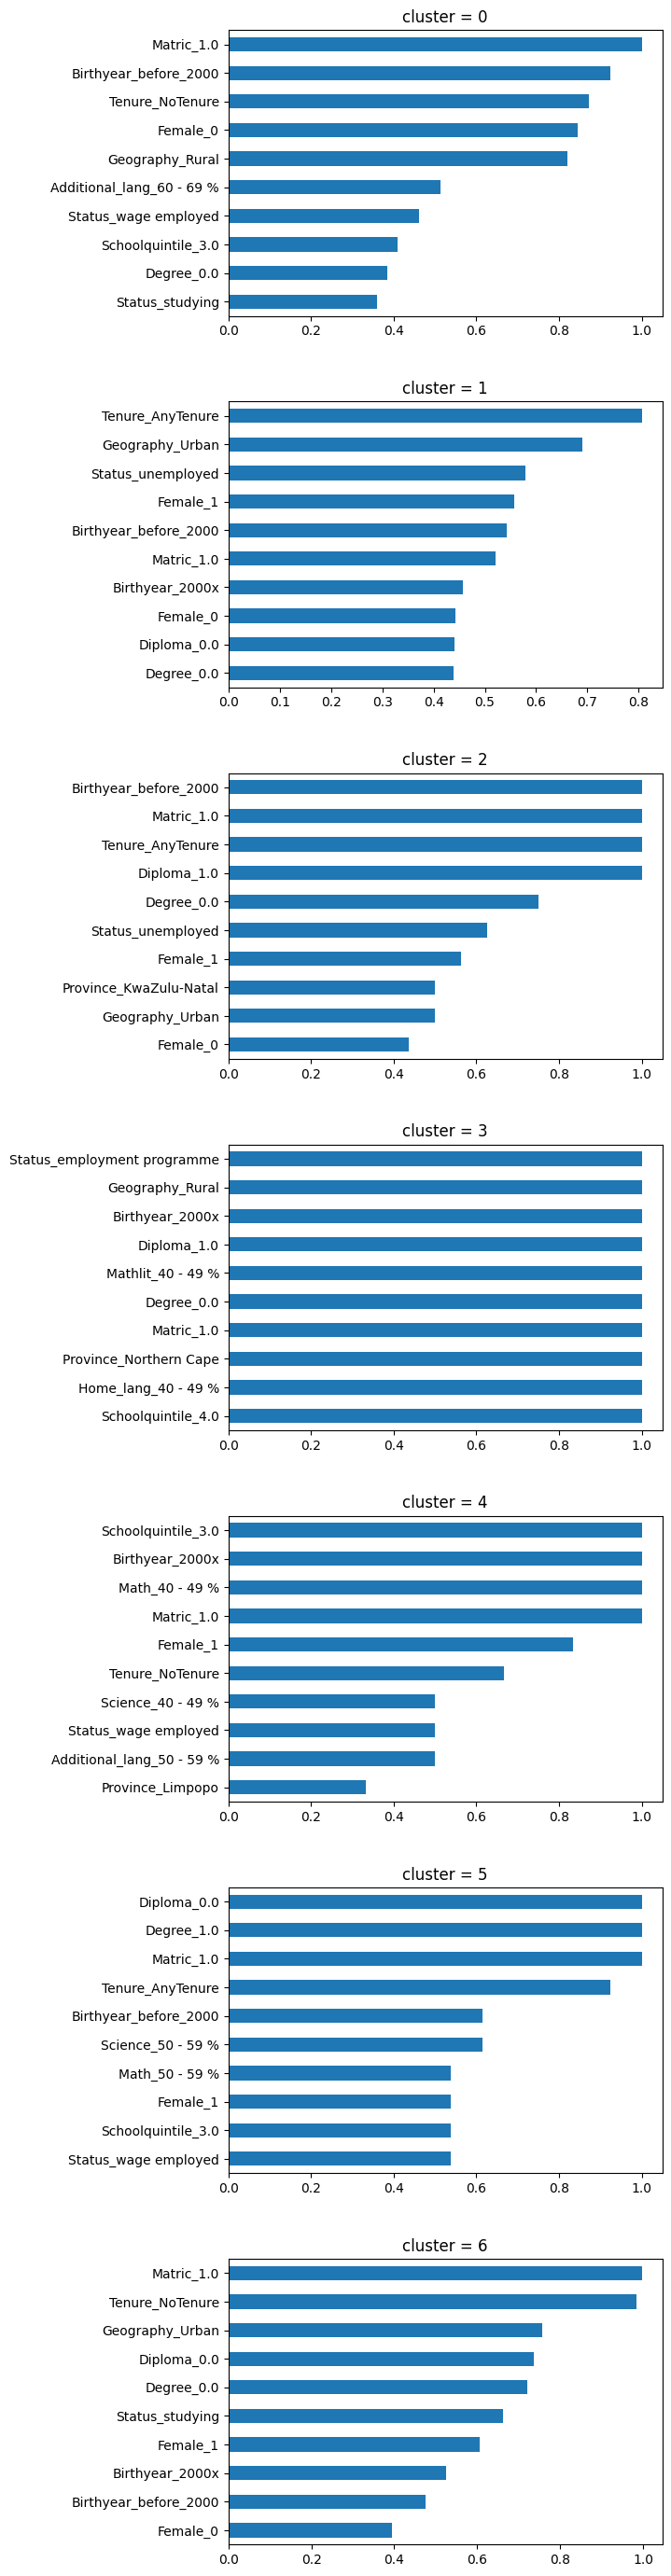

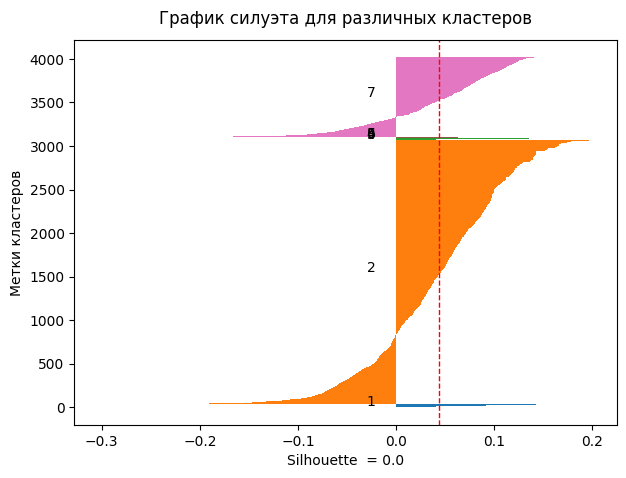

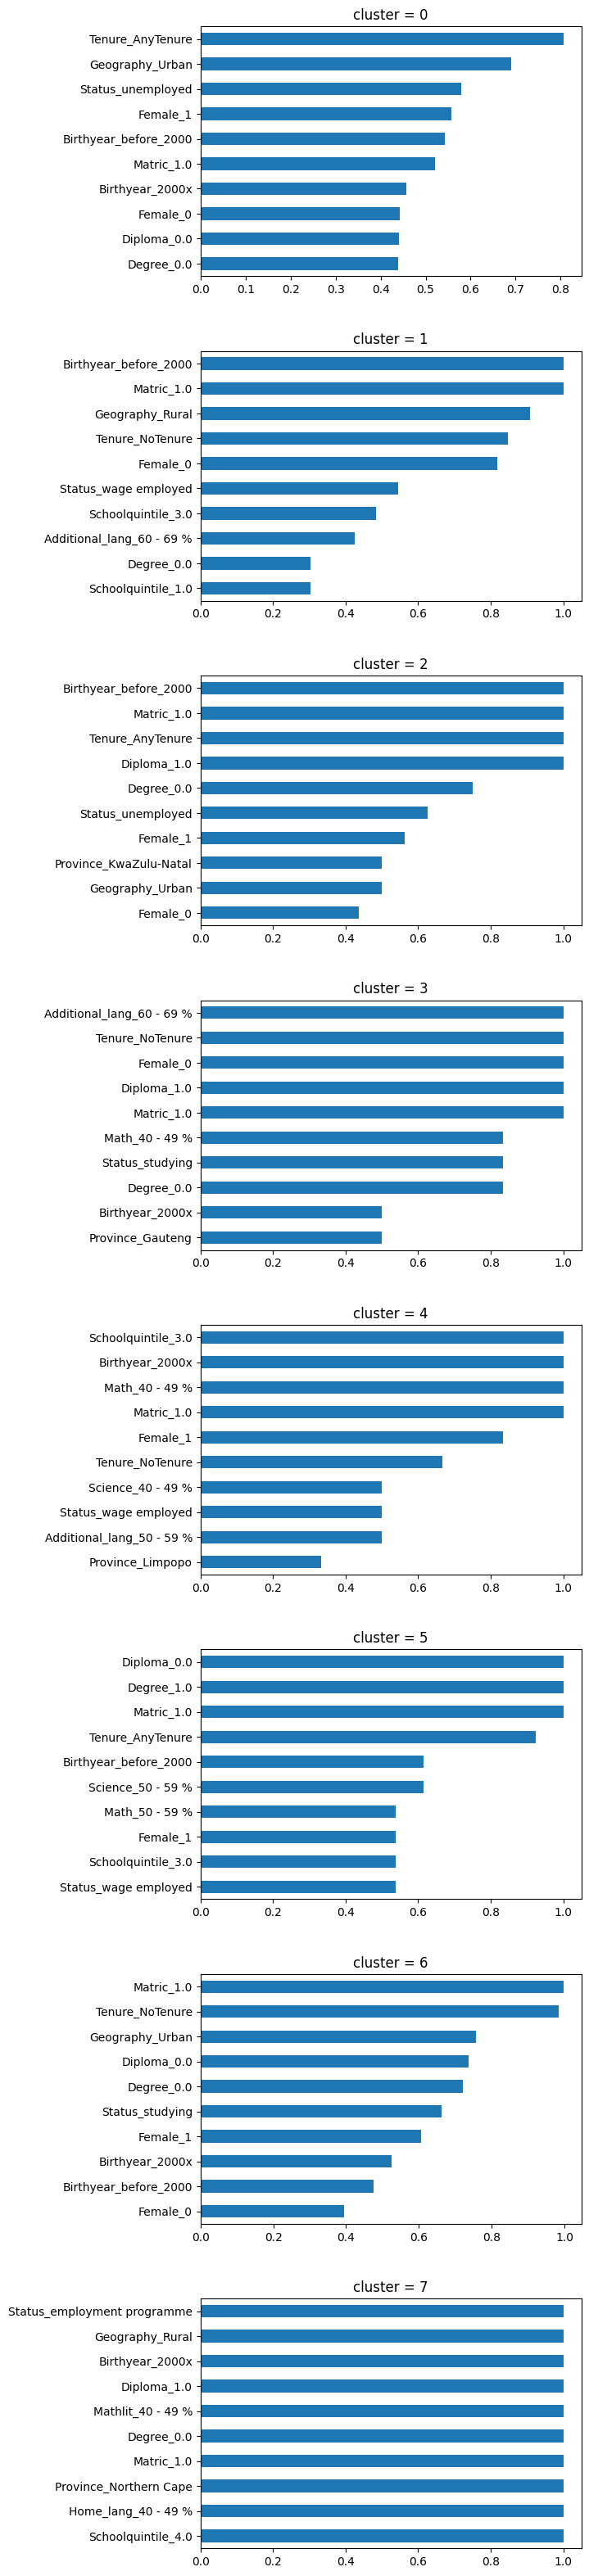

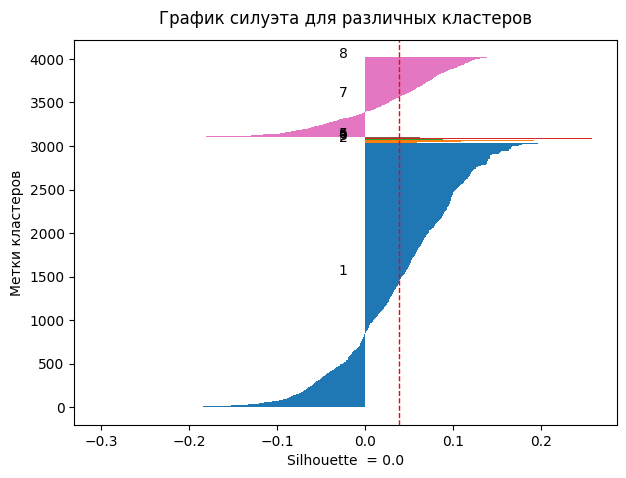

In [21]:
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering

i = 2
for linkage in range(min_size, max_size+1):
    clustering = AgglomerativeClustering(linkage='average', n_clusters=i)
    clustering.fit(Xb)
    plot_top_features(Xb, clustering.labels_, n_clusters=i)
    silhouette_plot(Xb, clustering.labels_)
    i+=1

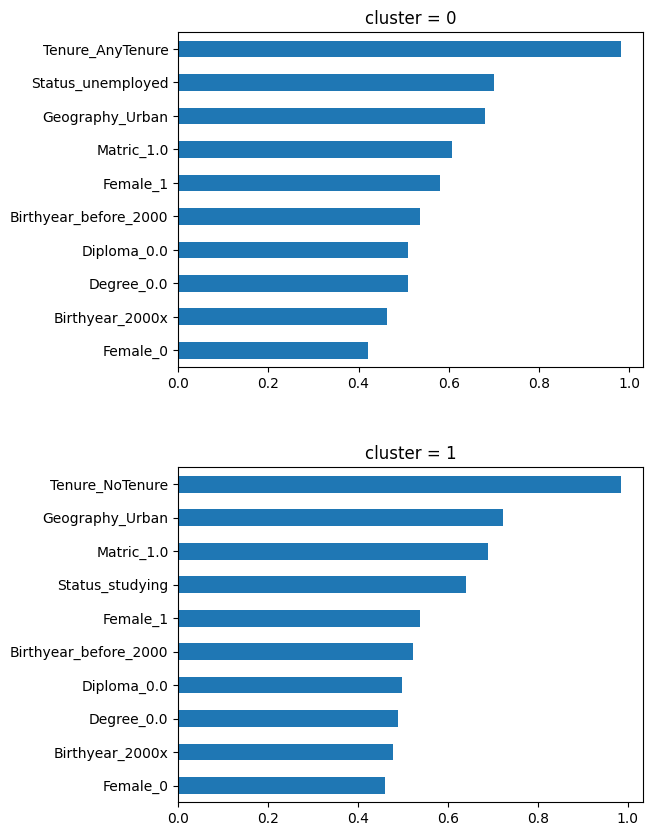

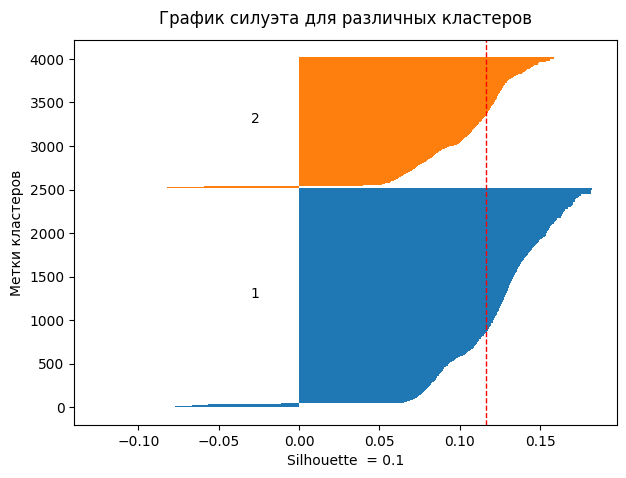

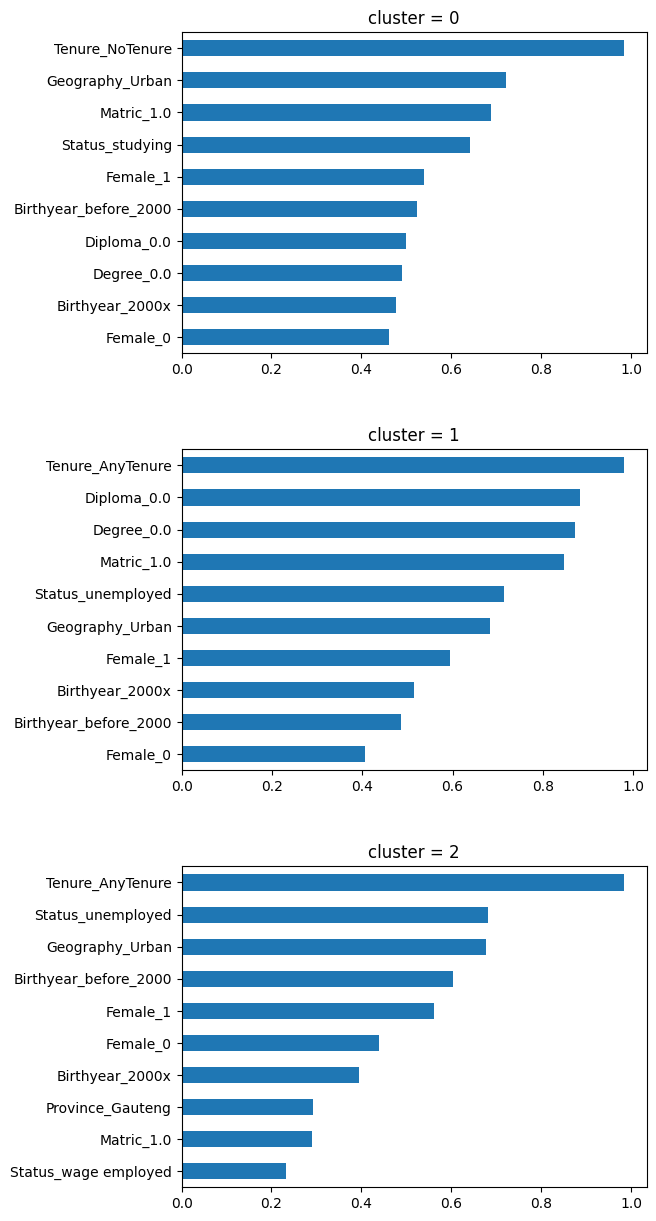

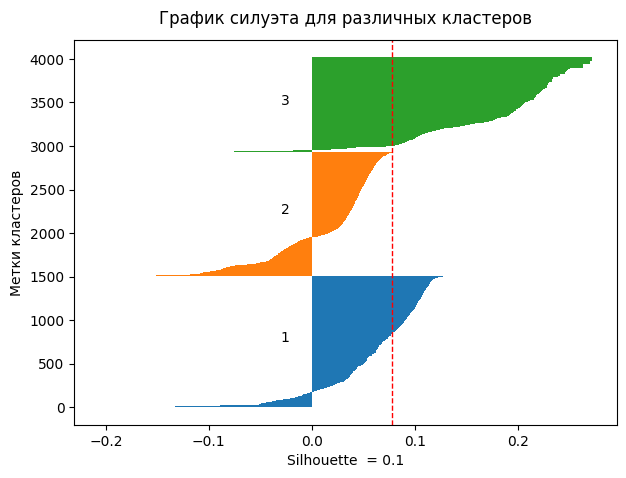

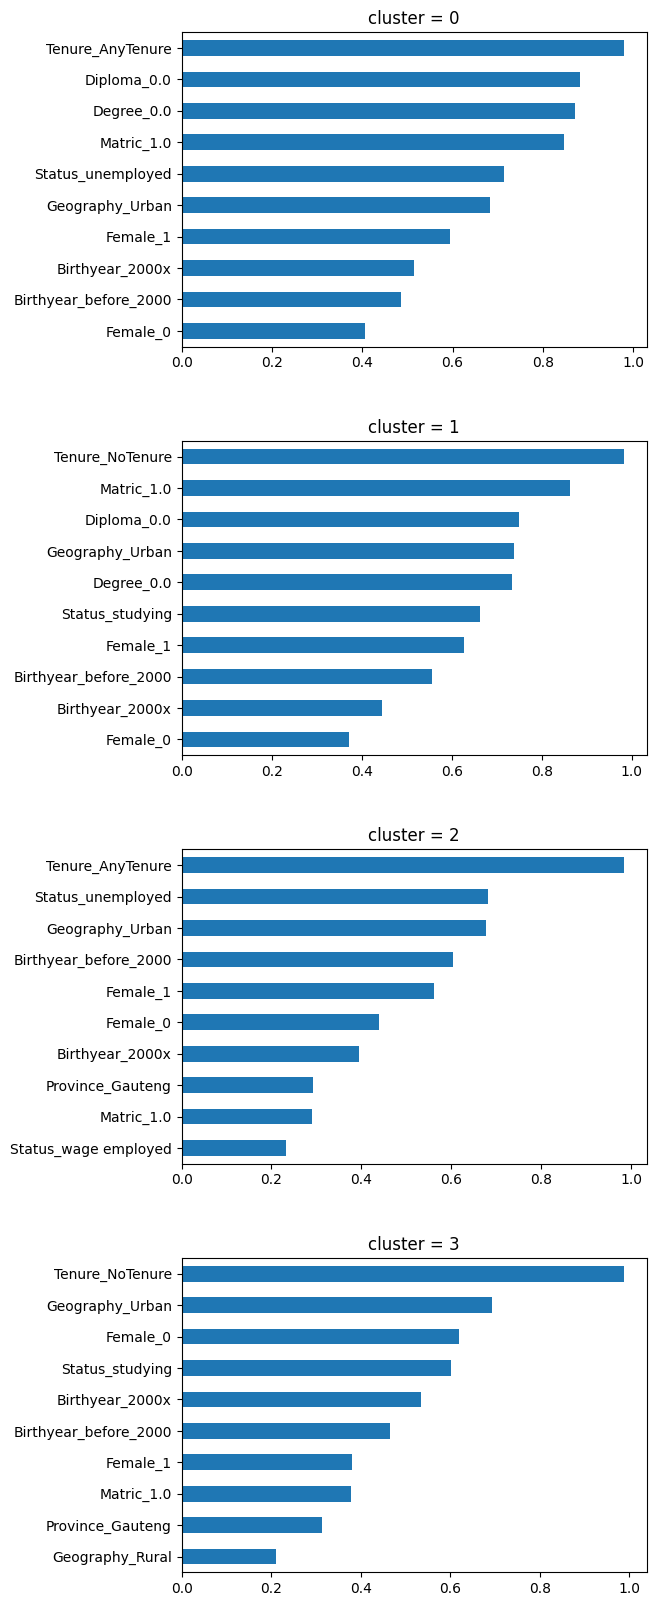

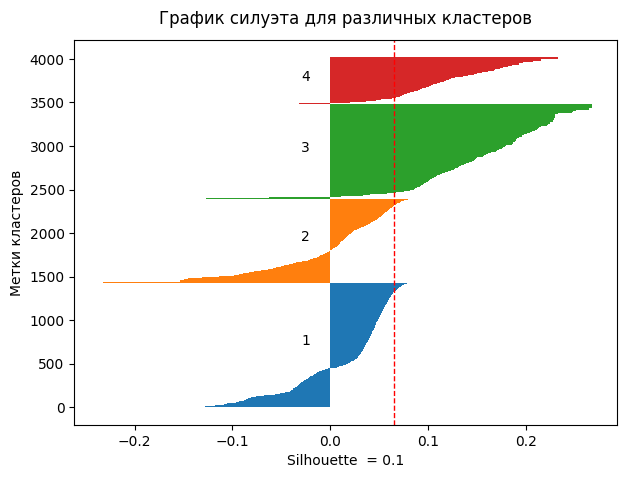

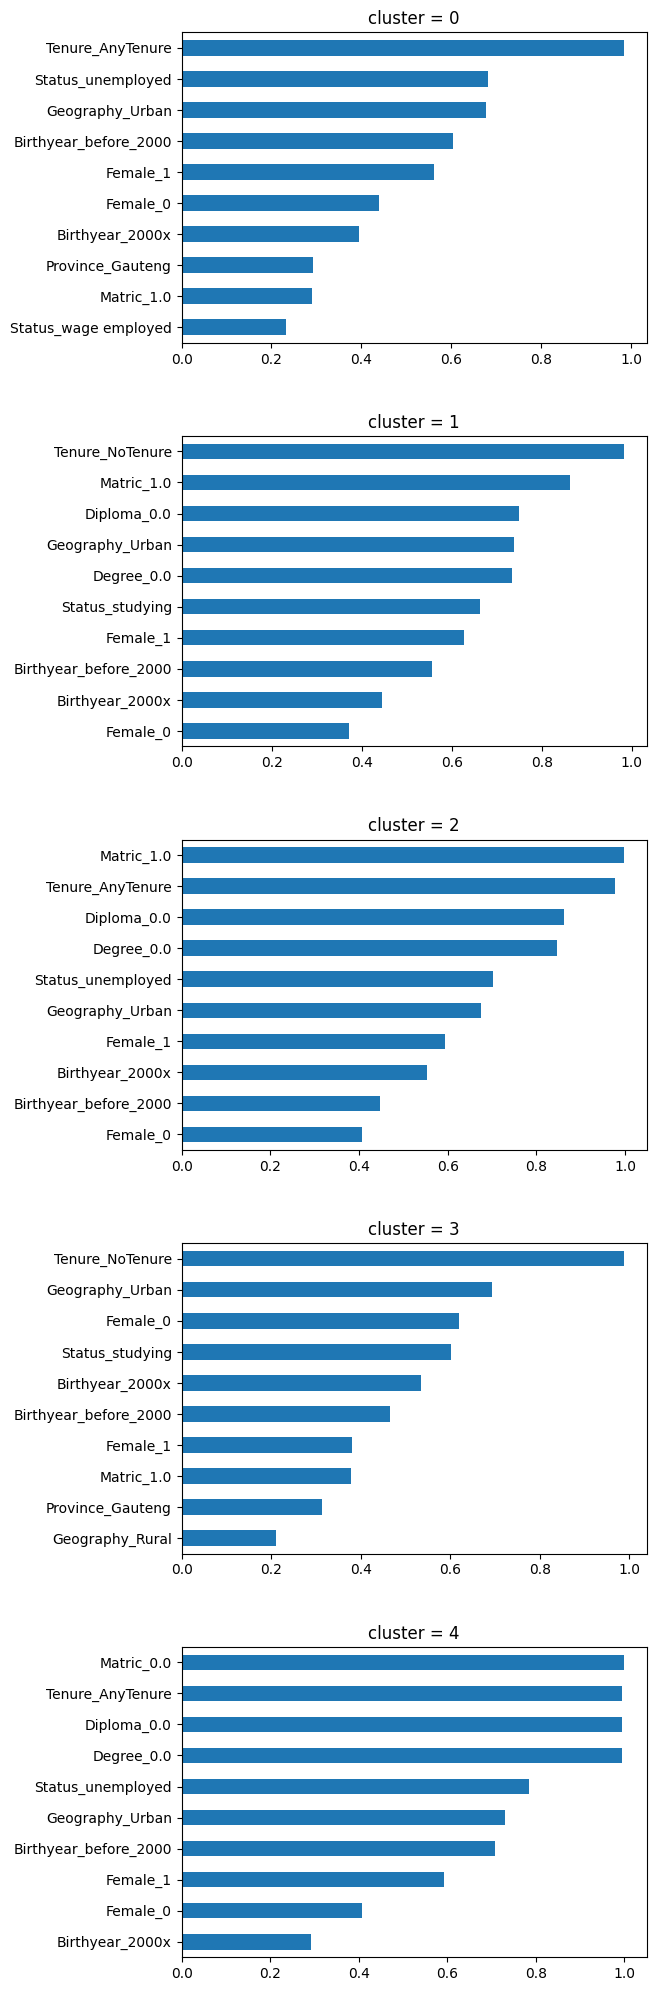

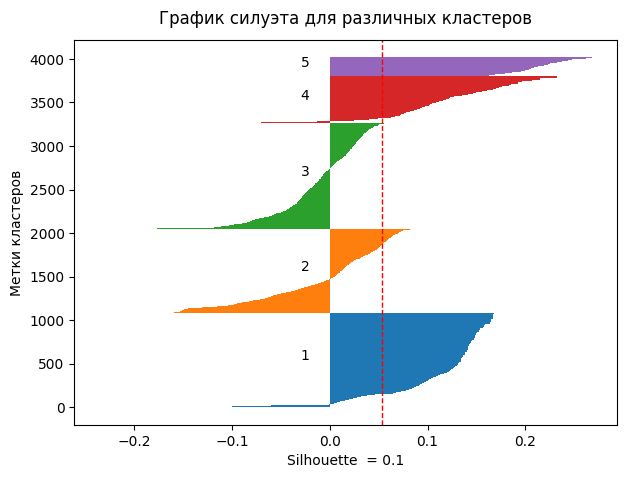

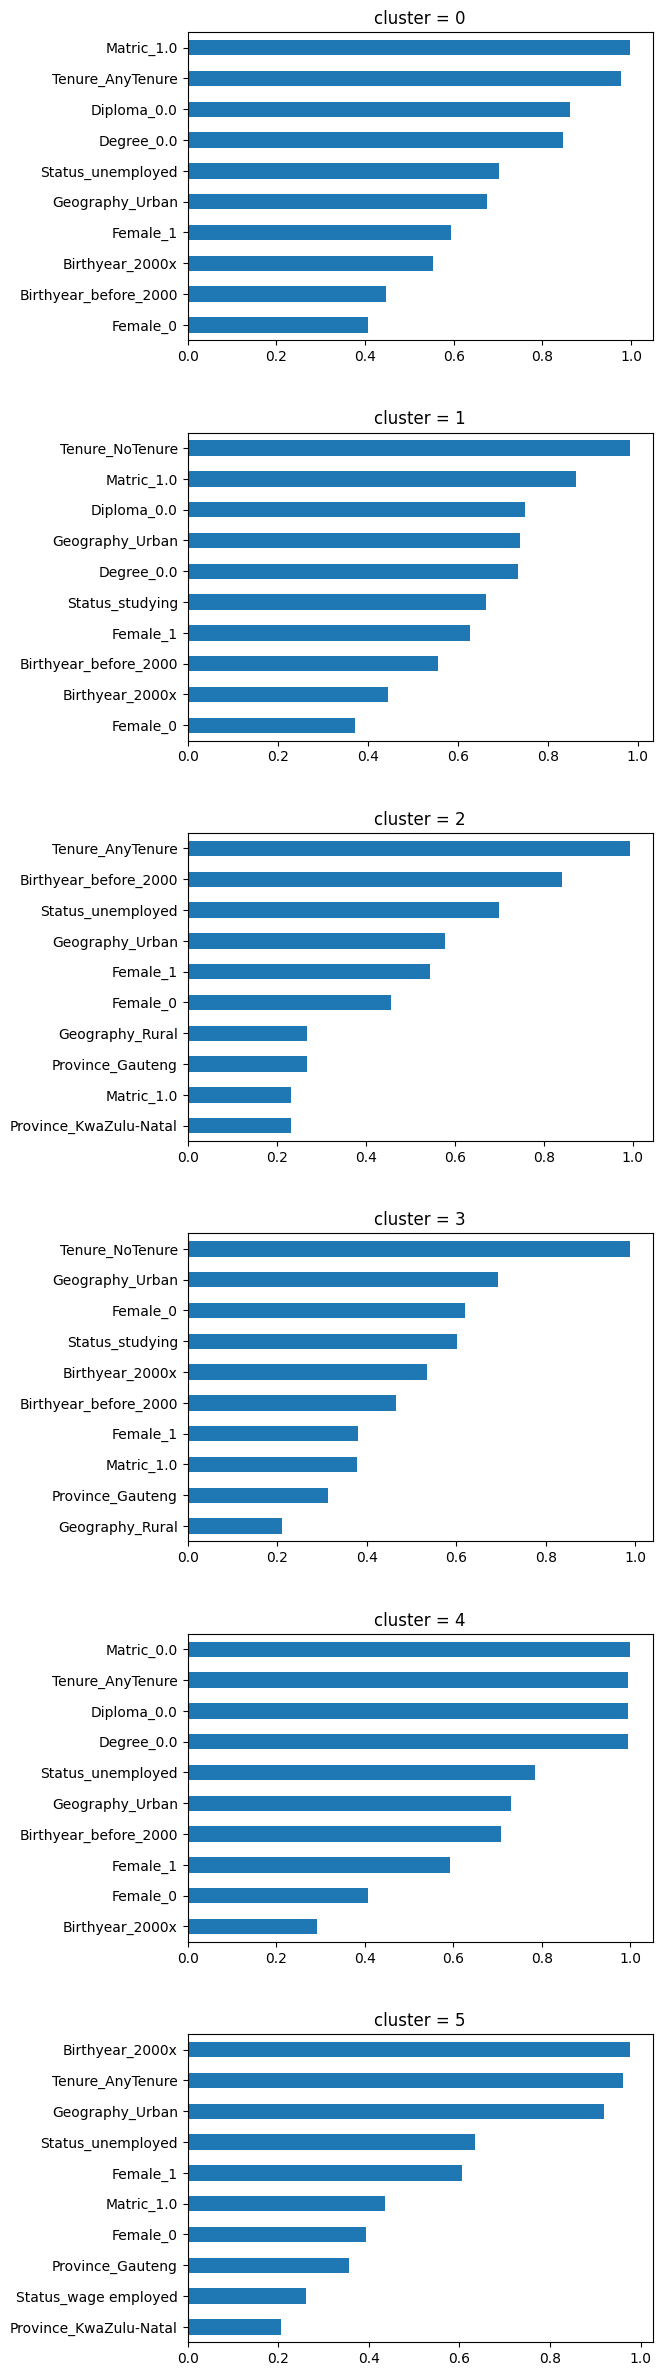

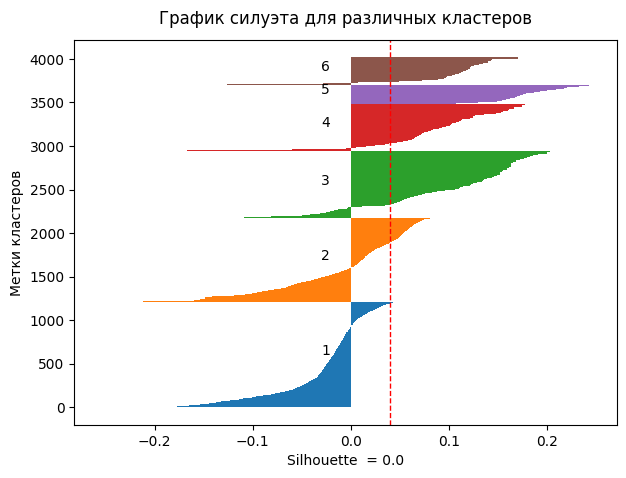

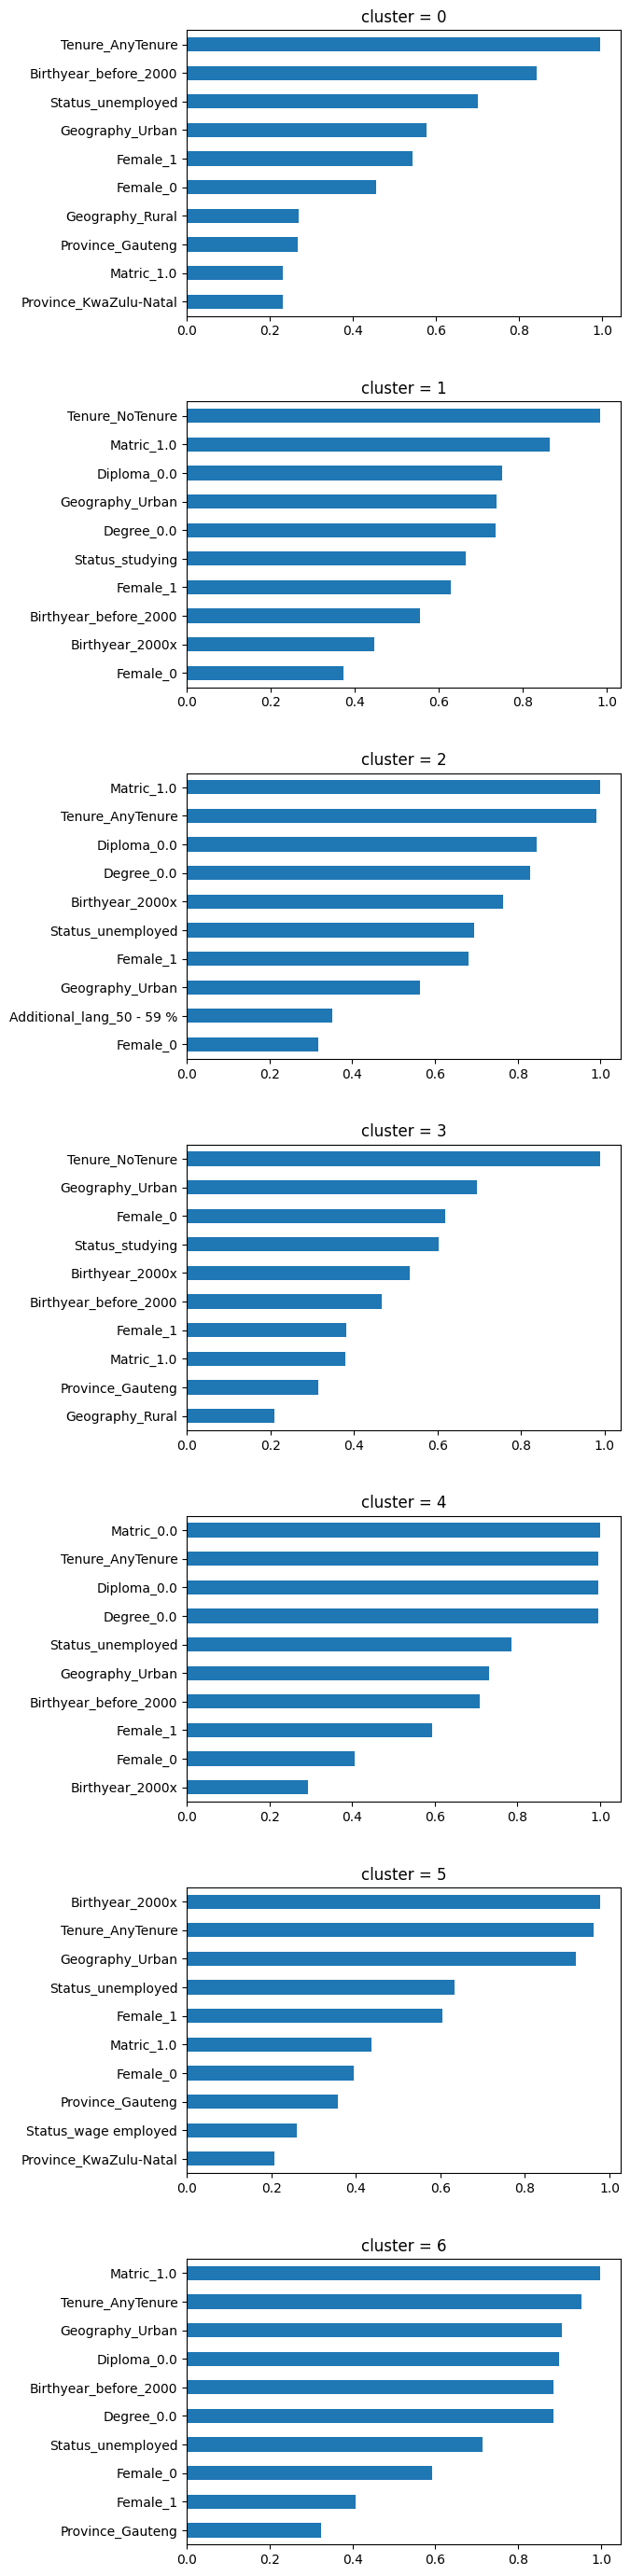

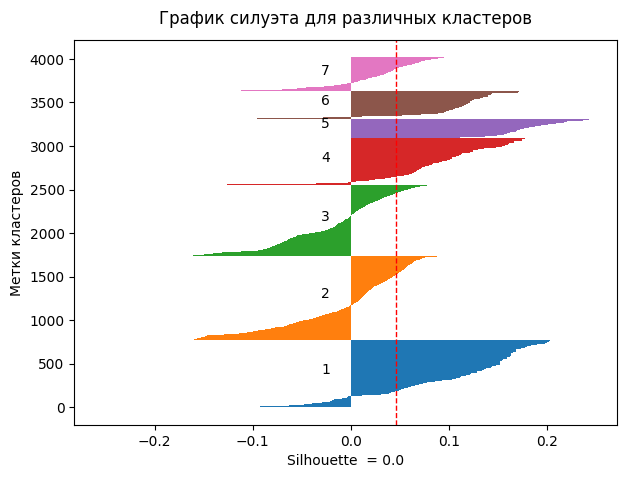

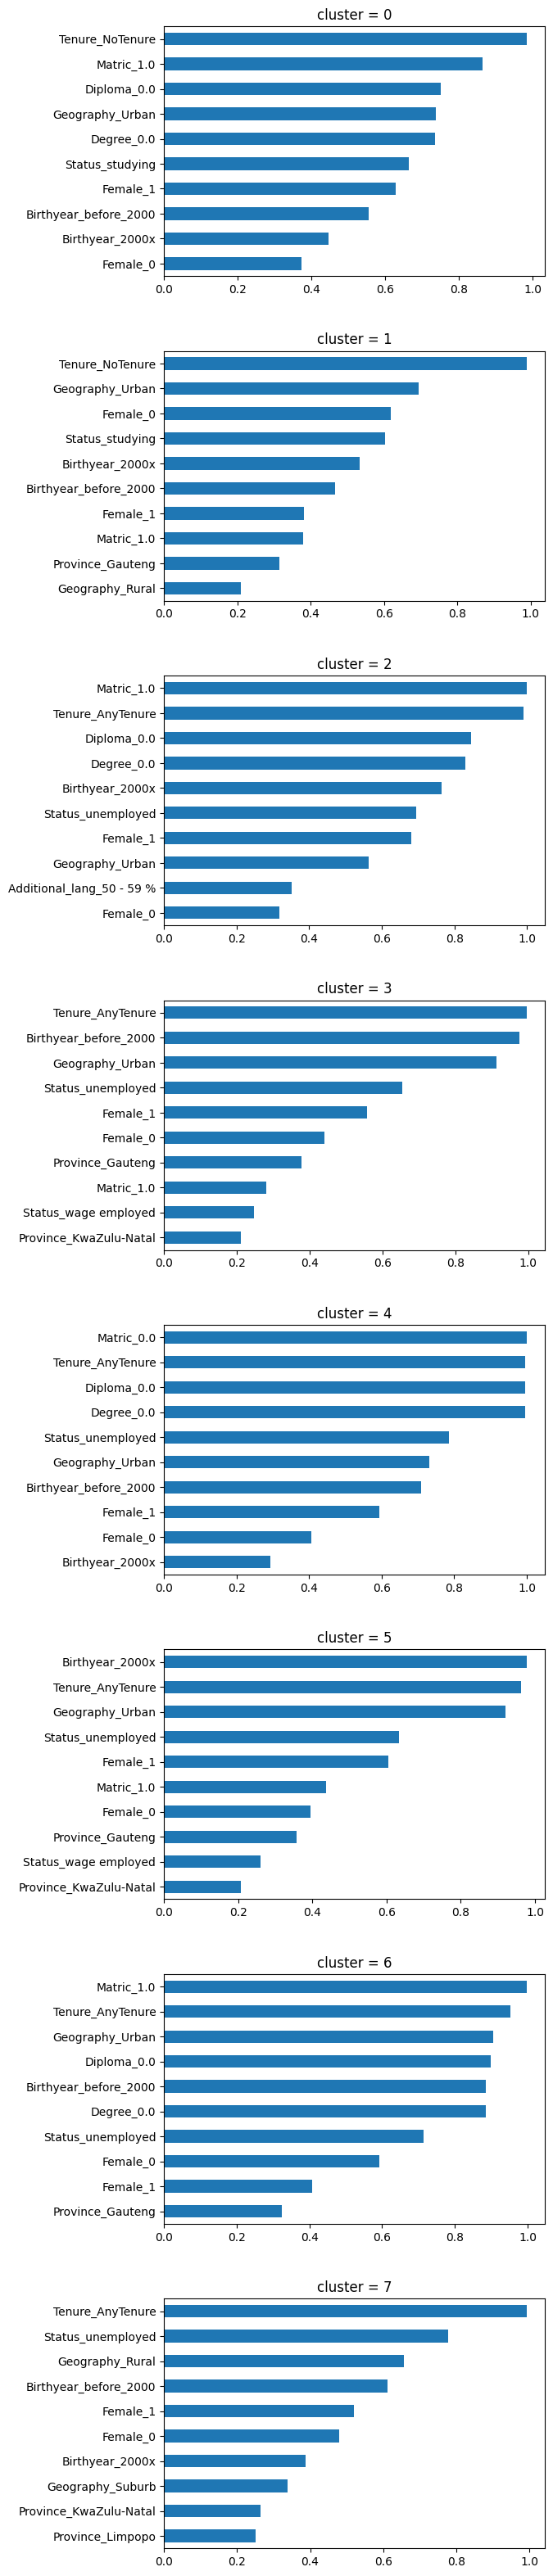

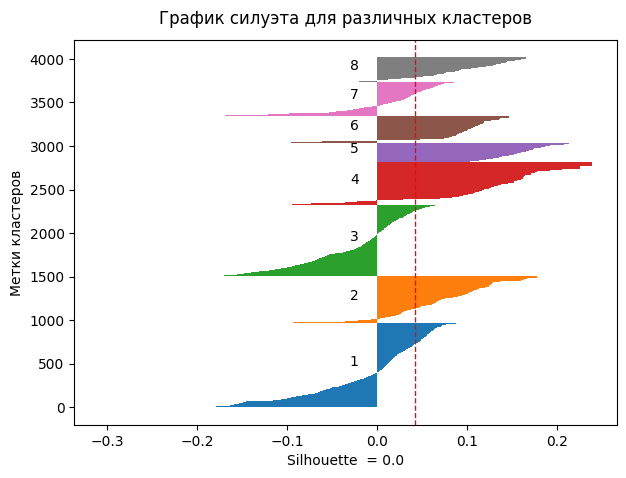

In [22]:
i = 2
for linkage in range(min_size, max_size+1):
    clustering = AgglomerativeClustering(linkage='ward', n_clusters=i)
    clustering.fit(Xb)
    plot_top_features(Xb, clustering.labels_, n_clusters=i)
    silhouette_plot(Xb, clustering.labels_)
    i+=1

In [ ]:
При помощи спектральной кластеризации хорошо выделились 2 и 5 кластеров, в которых несколько признаков в каждом кластере заполнены более 60%, часто даже 99-100%. 
Аггломеративная кластеризация хуже справилась с задачей, можно выделить только 2 кластера с погрешностями.
Применим спектральную кластеризацию, опишем подробнее в следующем разделе и посмотрим, какое ожидание по трудоустройству для каждого.

# Анализ кластеров, полученных методом спектральной кластеризации

In [23]:
clf_final = SpectralClustering(n_clusters=5, affinity='cosine', random_state=10)
clf_final.fit(Xb)

df_cleaned = Xb.assign(clusters=clf_final.fit_predict(Xb))

При помощи спектральной кластеризации выделились 5 кластеров, в которых несколько признаков в каждом кластере заполнены более 60%, часто даже 99-100%. Опишем их подробно.

In [25]:
# Считаем кол-во объектов в каждом кластере
count = df_cleaned.groupby('clusters').count().iloc[:, :1].T.values

# Нормируем кол-во объектов в каждом из признаков в кластере на общее кол-во объектов в кластере
normalize = df_cleaned.groupby('clusters').sum().T / count * 100

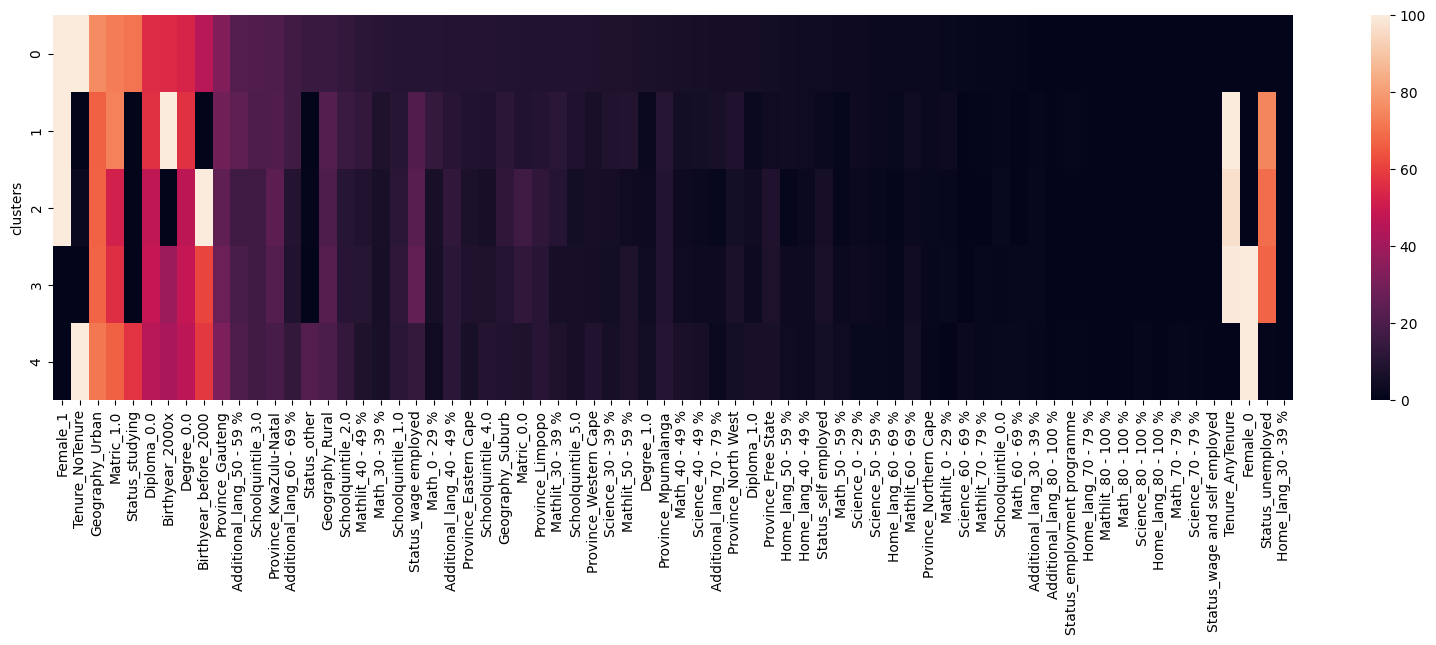

In [26]:
plt.figure(figsize=(20, 5))
sns.heatmap(normalize.sort_values(by = 0, axis=0, ascending=False).T);

Выведем признаки по каждому кластеру, т.к. число компонент было 30, будем выводить до 30 для удобства.

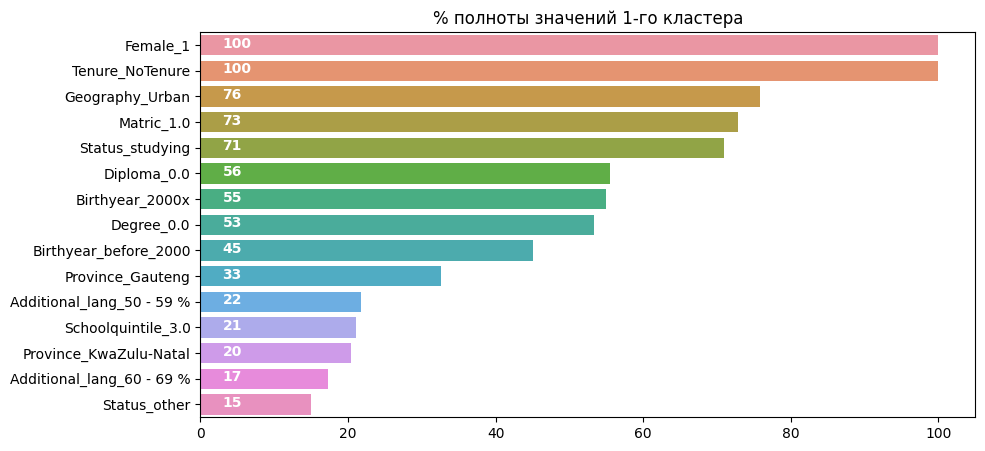

In [27]:
plt.figure(figsize=(10, 5))
plt.title('% полноты значений 1-го кластера', fontsize=12)
sns.barplot(data=normalize.iloc[:,0:1].sort_values(by=0, ascending=False).T.iloc[:, 0:15], orient='h')
# Выведем значения весов на бары
for index, value in enumerate(normalize.iloc[:,0].sort_values(ascending=False)):
    label = format(f"{value:.0f}")
    plt.annotate(label, xy =(3, index+0.1), color='white',fontweight='bold')

<b> 1 кластер </b><br>
Городские студентки всех возрастов без стажа работы. У некоторых уровень владения базовым английским выше среднего

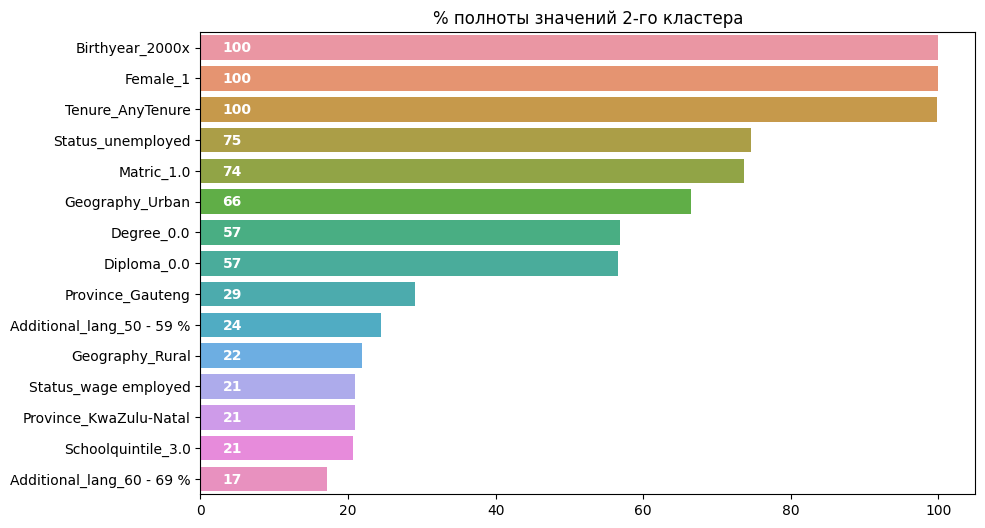

In [28]:
plt.figure(figsize=(10, 6))
plt.title('% полноты значений 2-го кластера', fontsize=12)
sns.barplot(data=normalize.iloc[:,1:2].sort_values(by=1, ascending=False).T.iloc[:, 0:15], orient='h')
# Выведем значения весов на бары
for index, value in enumerate(normalize.iloc[:,1].sort_values(ascending=False)):
    label = format(f"{value:.0f}")
    plt.annotate(label, xy =(3, index+0.15), color='white',fontweight='bold')

 <b> 2 кластер </b><br>
Девушки до 23 лет, в основном городские, со школьным аттестатом без высшего образования, которые в основном ни работают, ни учатся. У некоторых уровень владения английским выше среднего.

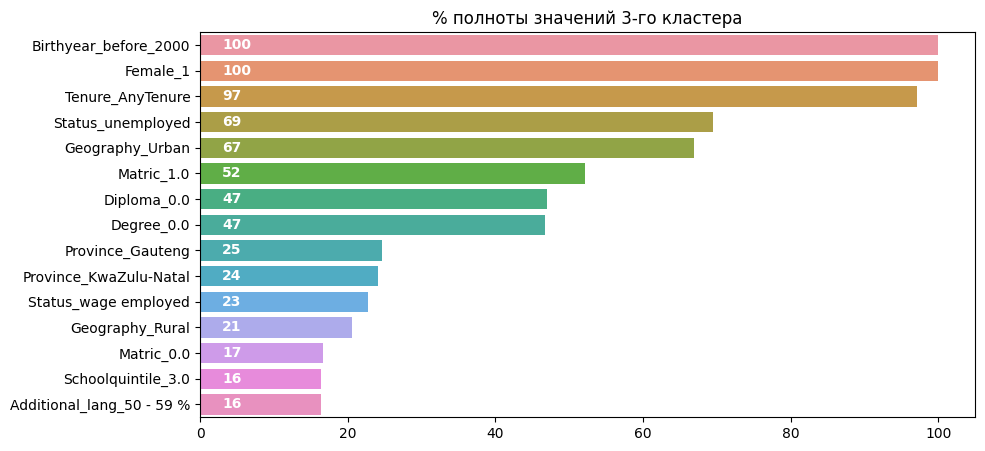

In [29]:
plt.figure(figsize=(10, 5))
plt.title('% полноты значений 3-го кластера', fontsize=12)
sns.barplot(data=normalize.iloc[:, 2:3].sort_values(by=2, ascending=False).T.iloc[:, 0:15], orient='h')
# Выведем значения весов на бары
for index, value in enumerate(normalize.iloc[:,2].sort_values(ascending=False)):
    label = format(f"{value:.0f}")
    plt.annotate(label, xy =(3, index+0.15), color='white',fontweight='bold')

<b>3 кластер</b>
Женщины старше 23 лет, в основном городские, со школьным аттестатом без высшего образования, которые в основном ни работают, ни учатся. Немногие рабоают по найму.

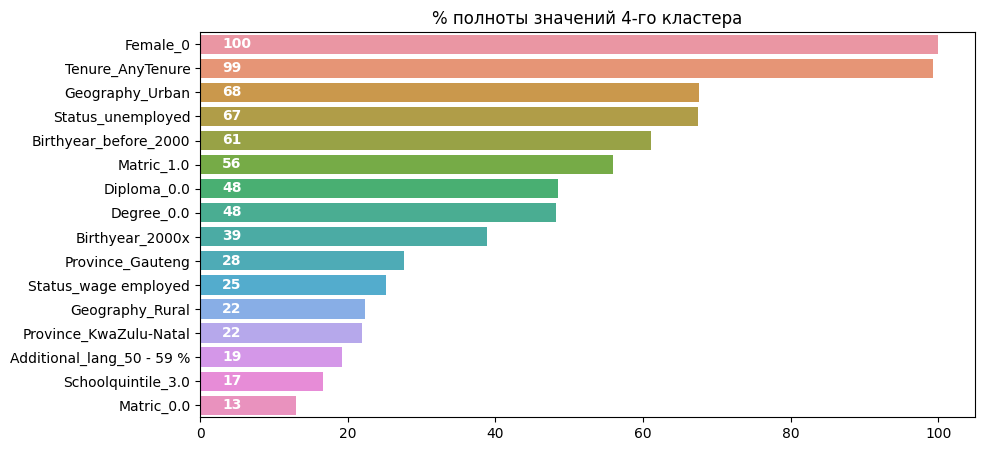

In [30]:
plt.figure(figsize=(10, 5))
plt.title('% полноты значений 4-го кластера', fontsize=12)
sns.barplot(data=normalize.iloc[:, 3:4].sort_values(by=3, ascending=False).T.iloc[:, 0:16], orient='h')
# Выведем значения весов на бары
for index, value in enumerate(normalize.iloc[:,3].sort_values(ascending=False)):
    label = format(f"{value:.0f}")
    plt.annotate(label, xy =(3, index+0.15), color='white',fontweight='bold')

<b>4 кластер</b>
Городские мужчины всех возратов со школьным аттестатом без высшего образования, в основном безработные. Немногие рабоают по найму. Большая часть молодые.

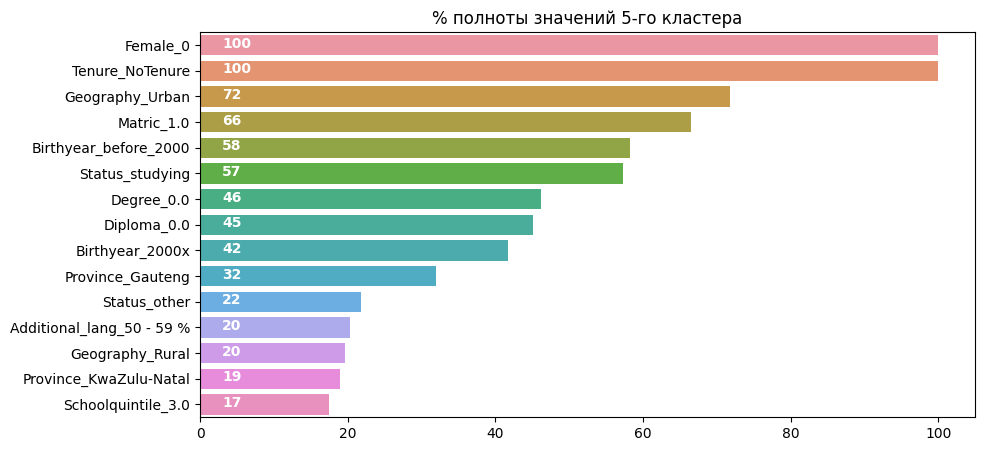

In [31]:
plt.figure(figsize=(10, 5))
plt.title('% полноты значений 5-го кластера', fontsize=12)
sns.barplot(data=normalize.iloc[:, 4:5].sort_values(by=4, ascending=False).T.iloc[:, 0:15], orient='h')
# Выведем значения весов на бары
for index, value in enumerate(normalize.iloc[:,4].sort_values(ascending=False)):
    label = format(f"{value:.0f}")
    plt.annotate(label, xy =(3, index+0.1), color='white',fontweight='bold')

<b>5 кластер</b>
Мужчины старше 23 лет, со школьным аттестатом без вышего образования, занятые учебой или прочей деятельностью.<br>
В целом, "Не безработные мужчины".

<b>Предскажем трудоустройство для каждого кластера</b>

In [33]:
Pred = pd.concat([df_cleaned[['clusters']], df['Target']], axis=1)

In [34]:
# Переименуем кластеры для наглядности
Pred.replace({'clusters' : { 0 : 'Studying women', 1 : 'Unemployed girls', 2: 'Unemployed elder women', \
                          3: 'Unemployed men', 4: 'Studying or employed men'}}, inplace = True)

In [35]:
def barplot_group(df_data: pd.DataFrame, col_main: str, col_group: str,
                  title: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(col_group))

    ax = sns.barplot(x=col_main,
                     y="percentage",
                     hue=col_group,
                     data=data,
                     palette="pastel"
                     )

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
            ha='center',  # центрирование
            va='center',
            xytext=(0, 7),
            textcoords='offset points',  # точка смещения относительно координаты
            fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

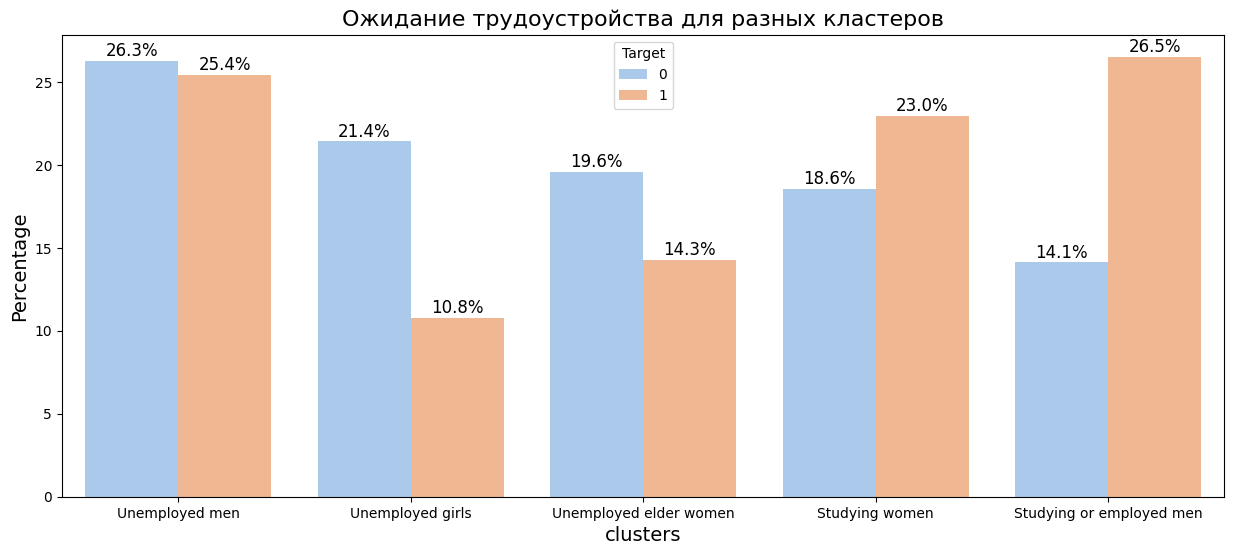

In [36]:
barplot_group(Pred, "clusters", "Target", 'Ожидание трудоустройства для разных кластеров')

Более всего ожидается, что трудоустроенными  в течение года будут мужчины любого возраста, которые сейчас учатся или работают. Причем перевес в вероятности найти работу здесь самый большой и среди других категорий, и внутри кластера. <br>
Так же ожидается, что среди студенток будет больше тех, кто найдет работу.<br>
Перевес безработных ожидается среди женщин всех возрастов со школьным образованием, которые сейчас ни работают, ни учатся. Самая проблемная категория здесь - девушки до 23 лет.<br>
Таким образом, можно сделать вывод, что перевес трудоустроенных над безработными ожидается у уже занятых какой-либо деятельностью - работой или учебой. Но у студенток эта разница меньше. На это стоит обратить внимание.<br>
<br> В целом, результаты аналогичны интерпертации Шепли в ноутбуке с бейзлайном.<br>
 <br><i> Стоит так же обратить внимание на особенность африканской культуры, в которой до сих пор значимы традиционные ценности - семья и особенно дети. Даже в развитых странах негритянки часто готовы оставить учебу и работу ради создания семьи, несмотря на успехи и возможности.</i><br><br>
С учетом всех особенностей, необходимы социальные программы по трудоустройству в первую очередь для мужчин без высшего образования всех возратов (например, рабочие специальности), и поддержка молодых женщин, которые хотят работать или учиться. Среди молодежи повышать престиж социально занятого человека (если не хочет учиться, пусть идет работать или наоборот).